### Introduction

Through their lifetime, aircraft components are susceptible to degradation, directly affecting their reliability and performance. This machine learning project's aim will be to predict an aircraft's remaining useful life-cycle (RUL) based on their entire life-cycle data. Dataset consist of multiple multivaraite time series simulated data, where each time series is from a different engine. Engine degradation simulation was carried out using C-MAPSS; four different sets simulated under different combinations of initial conditions and fault modes. The objective is the predict the number of remaining operational cycles before failure in the test set, RUL.  

Through this project, I will explore the data, look for trends, feature engineer, remove unnecessary features, and run relevant parts of the data through regression and classification models (Linear, Random Forest, LSTM, etc.) to choose the best model with business in mind.

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

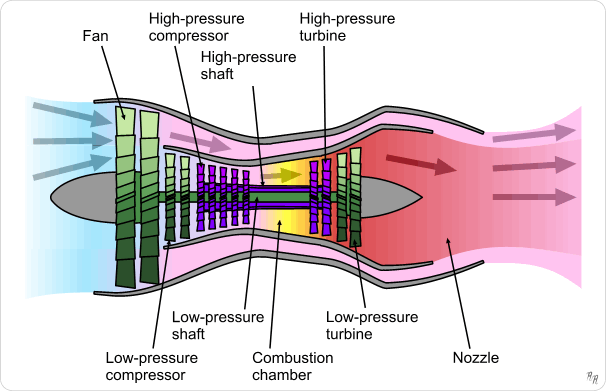

An illustration of a turbofan engine


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statistics
import random 
import warnings
import math
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, Masking, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import xgboost
import scipy
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam  # from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.losses import Huber
import keras.backend as K

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)

In [73]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['Fan Inlet Temperature', 'LPC Outlet Temperature', 'HPC Outlet Temperature',
                'LPT Outlet Temperature', ' Fan Inlet Pressure', 'Bypass-Duct Pressure', 
                'HPC Outlet Pressure', 'Physical Fan Speed', 'Physical Core Speed', 'Engine Pressure Ratio',
                'HPC Outlet Static Pressure', 'Ratio of Fuel Flow to Ps30', 'Corrected Fan Speed',
                'Corrected Core Speed', 'Bypass Ratio', 'Burner Fuel-Air Ratio',
                'Bleed Enthalpy', 'Required Fan Speed', 'Required Fan Conversion Speed',
                'High-Pressure Turbines Cool Air Flow', 'Low-Pressure Turbines Cool Air Flow']
col_names = index_names + setting_names + sensor_names

In [74]:
dftrain = pd.read_csv('/Users/.../NASA Turbofan Predictive Maintenance/CMaps/train_FD001.txt', sep = '\s+', header = None, index_col = False, names = col_names)
dftest = pd.read_csv('/Users/.../NASA Turbofan Predictive Maintenance/CMaps/test_FD001.txt', sep = '\s+', header = None, index_col = None, names = col_names)
valid = pd.read_csv('/Users/.../NASA Turbofan Predictive Maintenance/CMaps/RUL_FD001.txt', sep = '\s+', header = None, index_col = None, names = ['RUL'])

In [75]:
train = dftrain.copy()
test = dftest.copy()

In [76]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3  \
0                1            1    -0.0007    -0.0004      100.0   
1                1            2     0.0019    -0.0003      100.0   
2                1            3    -0.0043     0.0003      100.0   
3                1            4     0.0007     0.0000      100.0   
4                1            5    -0.0019    -0.0002      100.0   
...            ...          ...        ...        ...        ...   
20626          100          196    -0.0004    -0.0003      100.0   
20627          100          197    -0.0016    -0.0005      100.0   
20628          100          198     0.0004     0.0000      100.0   
20629          100          199    -0.0011     0.0003      100.0   
20630          100          200    -0.0032    -0.0005      100.0   

       Fan Inlet Temperature  LPC Outlet Temperature  HPC Outlet Temperature  \
0                     518.67                  641.82                 1589.70   
1                     518.67                  642.15                 1591.82   
2                     518.67                  642.35                 1587.99   
3                     518.67                  642.35                 1582.79   
4                     518.67                  642.37                 1582.85   
...                      ...                     ...                     ...   
20626                 518.67                  643.49                 1597.98   
20627                 518.67                  643.54                 1604.50   
20628                 518.67                  643.42                 1602.46   
20629                 518.67                  643.23                 1605.26   
20630                 518.67                  643.85                 1600.38   

       LPT Outlet Temperature   Fan Inlet Pressure  Bypass-Duct Pressure  \
0                     1400.60                14.62                 21.61   
1                     1403.14                14.62                 21.61   
2                     1404.20                14.62                 21.61   
3                     1401.87                14.62                 21.61   
4                     1406.22                14.62                 21.61   
...                       ...                  ...                   ...   
20626                 1428.63                14.62                 21.61   
20627                 1433.58                14.62                 21.61   
20628                 1428.18                14.62                 21.61   
20629                 1426.53                14.62                 21.61   
20630                 1432.14                14.62                 21.61   

       HPC Outlet Pressure  Physical Fan Speed  Physical Core Speed  \
0                   554.36             2388.06              9046.19   
1                   553.75             2388.04              9044.07   
2                   554.26             2388.08              9052.94   
3                   554.45             2388.11              9049.48   
4                   554.00             2388.06              9055.15   
...                    ...                 ...                  ...   
20626               551.43             2388.19              9065.52   
20627               550.86             2388.23              9065.11   
20628               550.94             2388.24              9065.90   
20629               550.68             2388.25              9073.72   
20630               550.79             2388.26              9061.48   

       Engine Pressure Ratio  HPC Outlet Static Pressure  \
0                        1.3                       47.47   
1                        1.3                       47.49   
2                        1.3                       47.27   
3                        1.3                       47.13   
4                        1.3                       47.28   
...                      ...                         ...   
20626                    1.3               

In [77]:
test

unit_number  time_cycles  setting_1  setting_2  setting_3  \
0                1            1     0.0023     0.0003      100.0   
1                1            2    -0.0027    -0.0003      100.0   
2                1            3     0.0003     0.0001      100.0   
3                1            4     0.0042     0.0000      100.0   
4                1            5     0.0014     0.0000      100.0   
...            ...          ...        ...        ...        ...   
13091          100          194     0.0049     0.0000      100.0   
13092          100          195    -0.0011    -0.0001      100.0   
13093          100          196    -0.0006    -0.0003      100.0   
13094          100          197    -0.0038     0.0001      100.0   
13095          100          198     0.0013     0.0003      100.0   

       Fan Inlet Temperature  LPC Outlet Temperature  HPC Outlet Temperature  \
0                     518.67                  643.02                 1585.29   
1                     518.67                  641.71                 1588.45   
2                     518.67                  642.46                 1586.94   
3                     518.67                  642.44                 1584.12   
4                     518.67                  642.51                 1587.19   
...                      ...                     ...                     ...   
13091                 518.67                  643.24                 1599.45   
13092                 518.67                  643.22                 1595.69   
13093                 518.67                  643.44                 1593.15   
13094                 518.67                  643.26                 1594.99   
13095                 518.67                  642.95                 1601.62   

       LPT Outlet Temperature   Fan Inlet Pressure  Bypass-Duct Pressure  \
0                     1398.21                14.62                 21.61   
1                     1395.42                14.62                 21.61   
2                     1401.34                14.62                 21.61   
3                     1406.42                14.62                 21.61   
4                     1401.92                14.62                 21.61   
...                       ...                  ...                   ...   
13091                 1415.79                14.62                 21.61   
13092                 1422.05                14.62                 21.61   
13093                 1406.82                14.62                 21.61   
13094                 1419.36                14.62                 21.61   
13095                 1424.99                14.62                 21.61   

       HPC Outlet Pressure  Physical Fan Speed  Physical Core Speed  \
0                   553.90             2388.04              9050.17   
1                   554.85             2388.01              9054.42   
2                   554.11             2388.05              9056.96   
3                   554.07             2388.03              9045.29   
4                   554.16             2388.01              9044.55   
...                    ...                 ...                  ...   
13091               553.41             2388.02              9142.37   
13092               553.22             2388.05              9140.68   
13093               553.04             2388.11              9146.81   
13094               553.37             2388.07              9148.85   
13095               552.48             2388.06              9155.03   

       Engine Pressure Ratio  HPC Outlet Static Pressure  \
0                        1.3                       47.20   
1                        1.3                       47.50   
2                        1.3                       47.50   
3                        1.3                       47.28   
4                        1.3                       47.31   
...                      ...                         ...   
13091                    1.3               

In [78]:
valid

RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

Begin by familiarizing myself with the data. How many columnms and rows are there? What are the descriptive statistics? Are the features normally distributed? What does each feature plot out like?

In [79]:
train.describe().transpose()

count         mean           std  \
unit_number                           20631.0    51.506568  2.922763e+01   
time_cycles                           20631.0   108.807862  6.888099e+01   
setting_1                             20631.0    -0.000009  2.187313e-03   
setting_2                             20631.0     0.000002  2.930621e-04   
setting_3                             20631.0   100.000000  0.000000e+00   
Fan Inlet Temperature                 20631.0   518.670000  0.000000e+00   
LPC Outlet Temperature                20631.0   642.680934  5.000533e-01   
HPC Outlet Temperature                20631.0  1590.523119  6.131150e+00   
LPT Outlet Temperature                20631.0  1408.933782  9.000605e+00   
 Fan Inlet Pressure                   20631.0    14.620000  1.776400e-15   
Bypass-Duct Pressure                  20631.0    21.609803  1.388985e-03   
HPC Outlet Pressure                   20631.0   553.367711  8.850923e-01   
Physical Fan Speed                    20631.0  2388.096652  7.098548e-02   
Physical Core Speed                   20631.0  9065.242941  2.208288e+01   
Engine Pressure Ratio                 20631.0     1.300000  0.000000e+00   
HPC Outlet Static Pressure            20631.0    47.541168  2.670874e-01   
Ratio of Fuel Flow to Ps30            20631.0   521.413470  7.375534e-01   
Corrected Fan Speed                   20631.0  2388.096152  7.191892e-02   
Corrected Core Speed                  20631.0  8143.752722  1.907618e+01   
Bypass Ratio                          20631.0     8.442146  3.750504e-02   
Burner Fuel-Air Ratio                 20631.0     0.030000  1.387812e-17   
Bleed Enthalpy                        20631.0   393.210654  1.548763e+00   
Required Fan Speed                    20631.0  2388.000000  0.000000e+00   
Required Fan Conversion Speed         20631.0   100.000000  0.000000e+00   
High-Pressure Turbines Cool Air Flow  20631.0    38.816271  1.807464e-01   
Low-Pressure Turbines Cool Air Flow   20631.0    23.289705  1.082509e-01   

                                            min        25%        50%  \
unit_number                              1.0000    26.0000    52.0000   
time_cycles                              1.0000    52.0000   104.0000   
setting_1                               -0.0087    -0.0015     0.0000   
setting_2                               -0.0006    -0.0002     0.0000   
setting_3                              100.0000   100.0000   100.0000   
Fan Inlet Temperature                  518.6700   518.6700   518.6700   
LPC Outlet Temperature                 641.2100   642.3250   642.6400   
HPC Outlet Temperature                1571.0400  1586.2600  1590.1000   
LPT Outlet Temperature                1382.2500  1402.3600  1408.0400   
 Fan Inlet Pressure                     14.6200    14.6200    14.6200   
Bypass-Duct Pressure                    21.6000    21.6100    21.6100   
HPC Outlet Pressure                    549.8500   552.8100   553.4400   
Physical Fan Speed                    2387.9000  2388.0500  2388.0900   
Physical Core Speed                   9021.7300  9053.1000  9060.6600   
Engine Pressure Ratio                    1.3000     1.3000     1.3000   
HPC Outlet Static Pressure              46.8500    47.3500    47.5100   
Ratio of Fuel Flow to Ps30             518.6900   520.9600   521.4800   
Corrected Fan Speed                   2387.8800  2388.0400  2388.0900   
Corrected Core Speed                  8099.9400  8133.2450  8140.5400   
Bypass Ratio                             8.3249     8.4149     8.4389   
Burner Fuel-Air Ratio                    0.0300     0.0300     0.0300   
Bleed Enthalpy                         388.0000   392.0000   393.0000   
Required Fan Speed                    2388.0000  2388.0000  2388.0000   
Required Fan Conversion Speed          100.0000   100.0000   100.0000   
High-Pressure Turbines Cool Air Flow    38.1400    38.7000    38.8300   
Low-Pressure Turbines Cool Air Flow     22.8942    23.2218    23.2979   

               

In [80]:
train.isna().sum()

unit_number                             0
time_cycles                             0
setting_1                               0
setting_2                               0
setting_3                               0
Fan Inlet Temperature                   0
LPC Outlet Temperature                  0
HPC Outlet Temperature                  0
LPT Outlet Temperature                  0
 Fan Inlet Pressure                     0
Bypass-Duct Pressure                    0
HPC Outlet Pressure                     0
Physical Fan Speed                      0
Physical Core Speed                     0
Engine Pressure Ratio                   0
HPC Outlet Static Pressure              0
Ratio of Fuel Flow to Ps30              0
Corrected Fan Speed                     0
Corrected Core Speed                    0
Bypass Ratio                            0
Burner Fuel-Air Ratio                   0
Bleed Enthalpy                          0
Required Fan Speed                      0
Required Fan Conversion Speed     

As excpected, there are 20631 rows, and the units go from 1 to 100. We can see from the max, that the unit with the highest time cycle lasted for 362 cycles. The mean and the quintiles for the descriptive stats are telling us something interesting. 75% of the engines have a maximum below 160, hinting that there are outliers among our engines and their readings.



There are 26 features and I want to visualize the ones that change, the ones that provide information the train off of. I can visualize each one and then remove them one by one, but I find it easier to remove all the features that have 0 STD, indicating the same values all the way thru. 

In [81]:
stats = train.describe()
zero_std = stats.columns[(stats.loc['std'] < 0.0001)]
train = train.drop(columns=zero_std)

(array([ 4.,  3., 11.,  7.,  8., 16., 13., 11.,  6.,  4.,  1.,  4.,  4.,
         3.,  1.,  1.,  0.,  1.,  1.,  1.]),
 array([128. , 139.7, 151.4, 163.1, 174.8, 186.5, 198.2, 209.9, 221.6,
        233.3, 245. , 256.7, 268.4, 280.1, 291.8, 303.5, 315.2, 326.9,
        338.6, 350.3, 362. ]),
 <BarContainer object of 20 artists>)

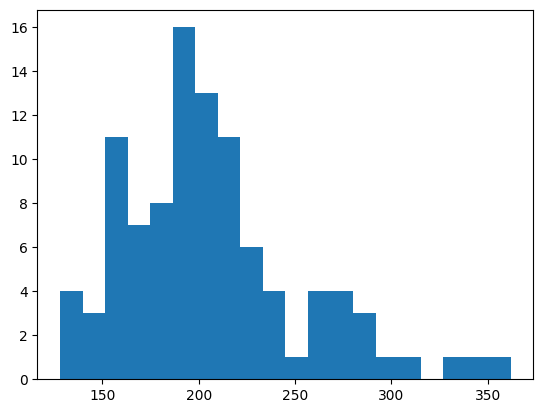

In [82]:
train_max = train.groupby('unit_number')['time_cycles'].max().reset_index()
train_max.columns = ['unit_number', 'max_cycles']
plt.hist(train_max['max_cycles'], bins=20)

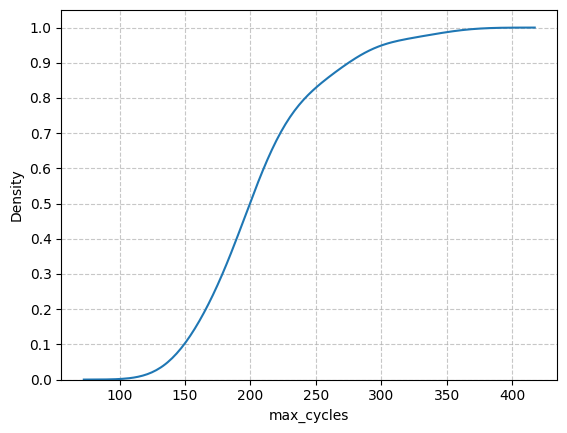

In [83]:
sns.kdeplot(data=train_max['max_cycles'], cumulative=True)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [84]:
train_max.describe()

unit_number  max_cycles
count   100.000000  100.000000
mean     50.500000  206.310000
std      29.011492   46.342749
min       1.000000  128.000000
25%      25.750000  177.000000
50%      50.500000  199.000000
75%      75.250000  229.250000
max     100.000000  362.000000

The histogram, cumulative kde, table and desciptive statistice tell us that a majority of cycles are between 150 and 250.  The difference from the smallest cycles and the highest cycle, 128 to 362, is 234. Notice that 50% of the max_cycles lie within 177 and 230, a range of 53 cycles. The 5 highest cycles, between 291 and 362, have a range of almost 70 cycles!

If we decided to cap our max_cycle in our training to improve efficiency, we would want to consider a cap that finds a balance between containing the most amount of engines and keeping the range of max_cycles to a minimum. A cap of 290 would remove 5% of our data, but also lower the range of our max_cycle by 30%, from 234 to 162.

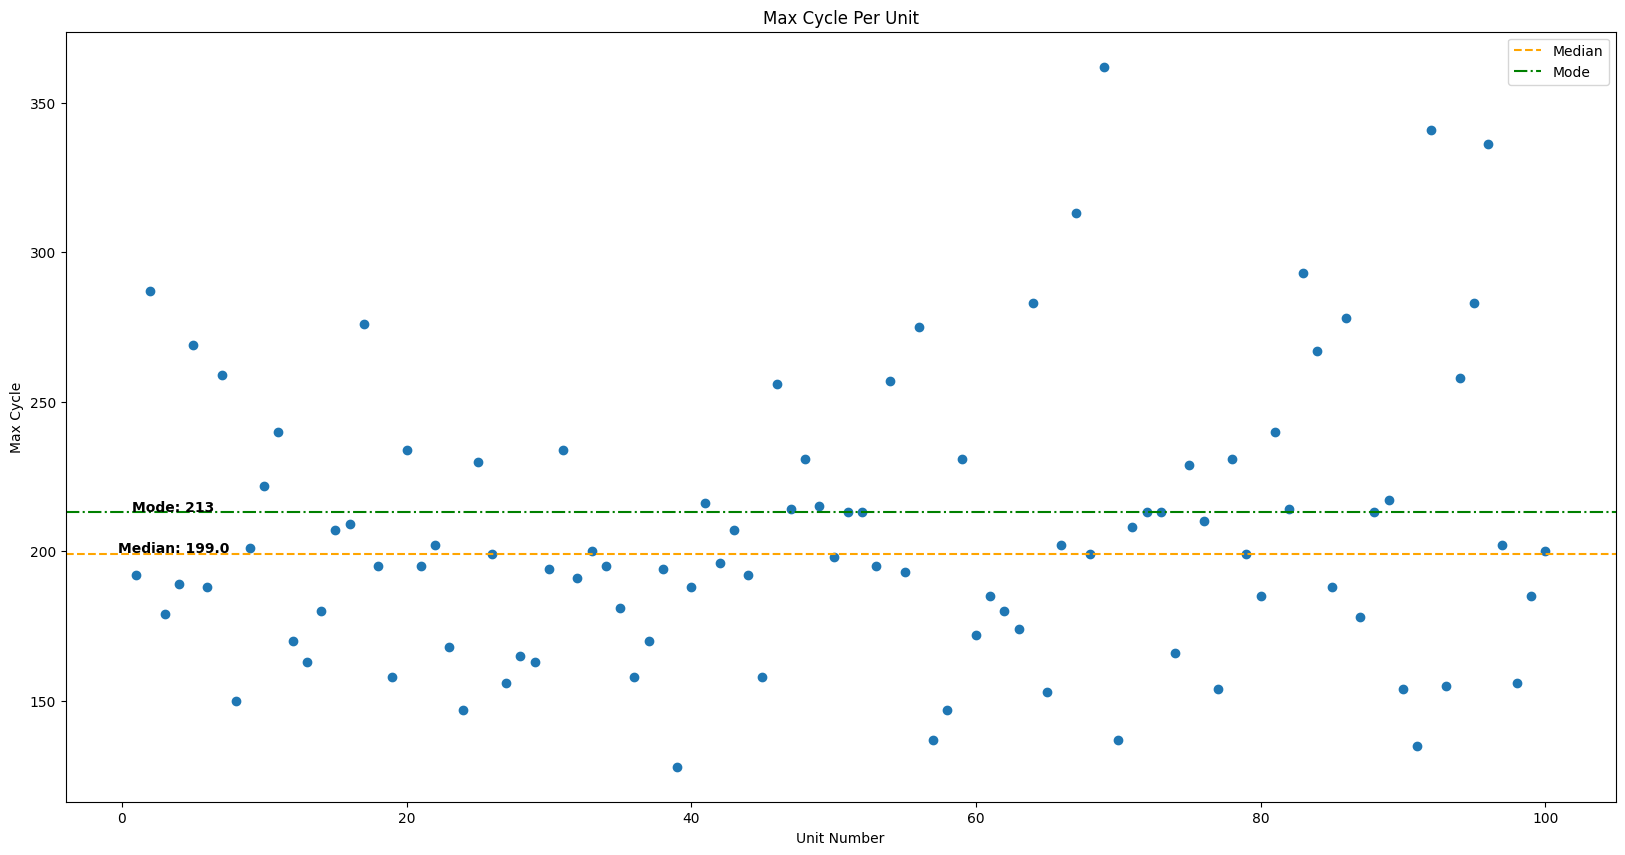

In [85]:
plt.figure(figsize=(20,10))
plt.xlabel('Unit Number')
plt.ylabel('Max Cycle')
plt.title('Max Cycle Per Unit')
plt.scatter(train_max['unit_number'], train_max['max_cycles'])

median_value = statistics.median(train_max['max_cycles'])
mode_value = statistics.mode(train_max['max_cycles'])

plt.axhline(y=median_value, color='orange', linestyle='--', label='Median')
plt.axhline(y=mode_value, color='green', linestyle='-.', label='Mode')
plt.text(-0.3, median_value + 0.5, f'Median: {median_value}', color='black', fontweight='bold')
plt.text(0.7, mode_value + 0.5, f'Mode: {mode_value}', color='black', fontweight='bold')

plt.legend()
plt.show()

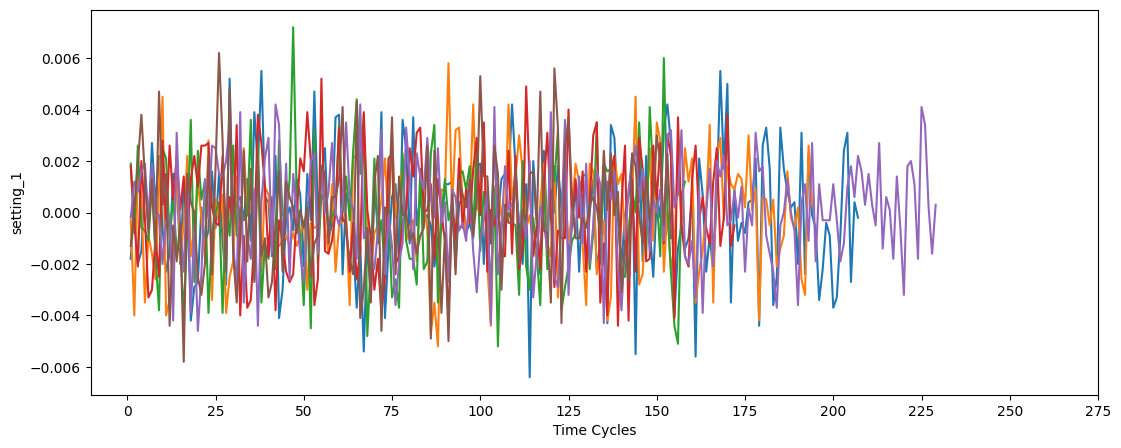

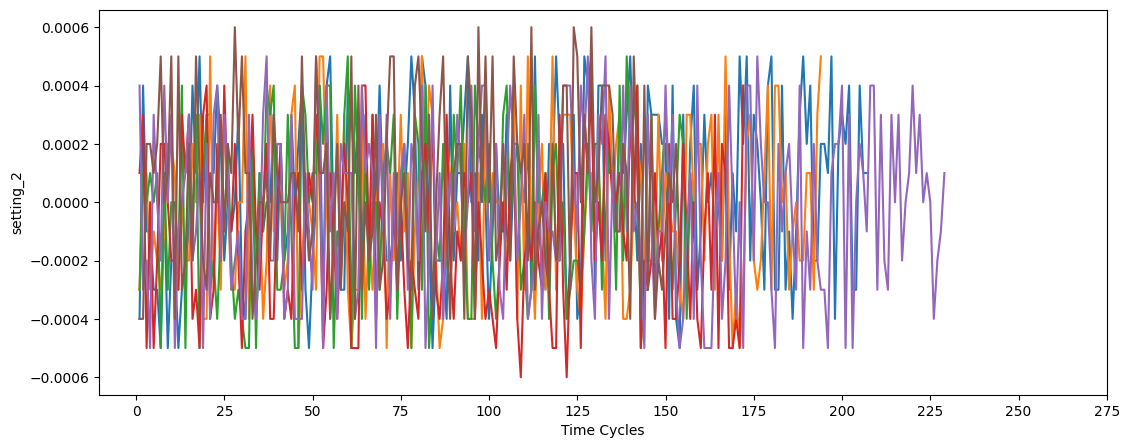

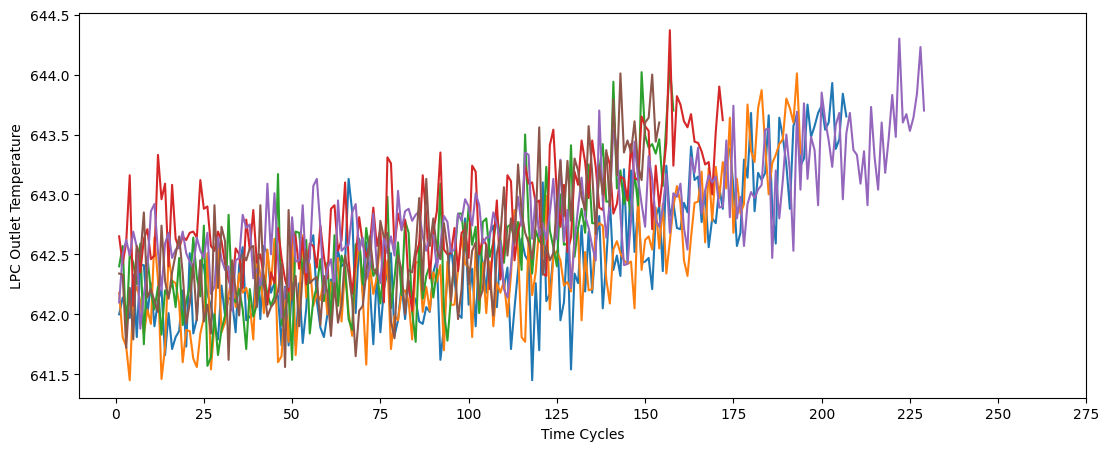

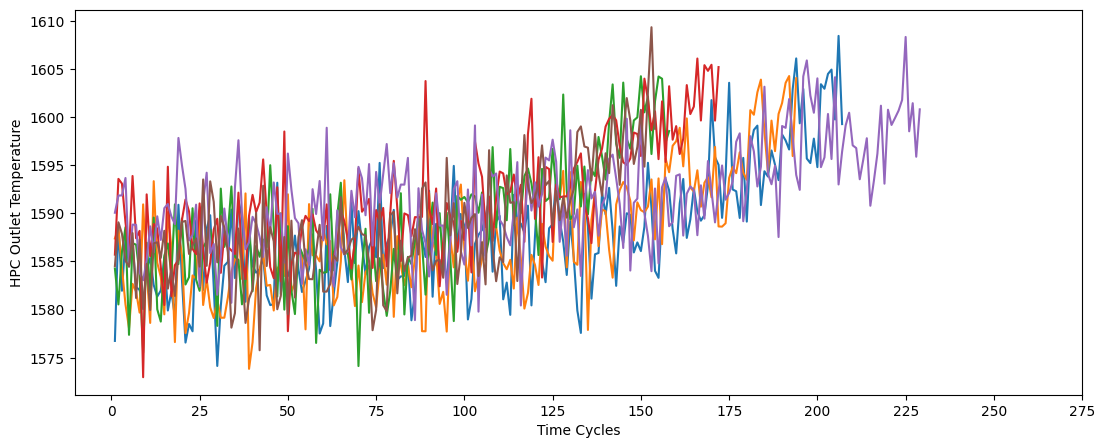

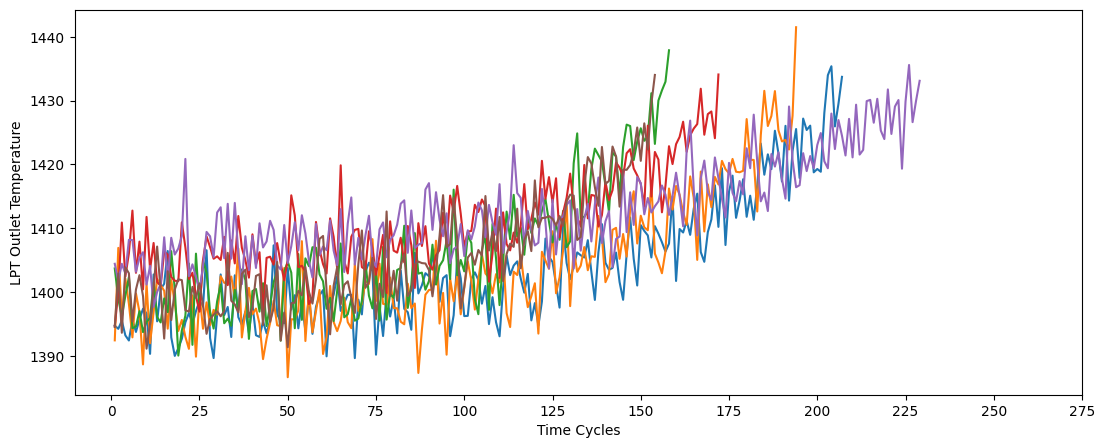

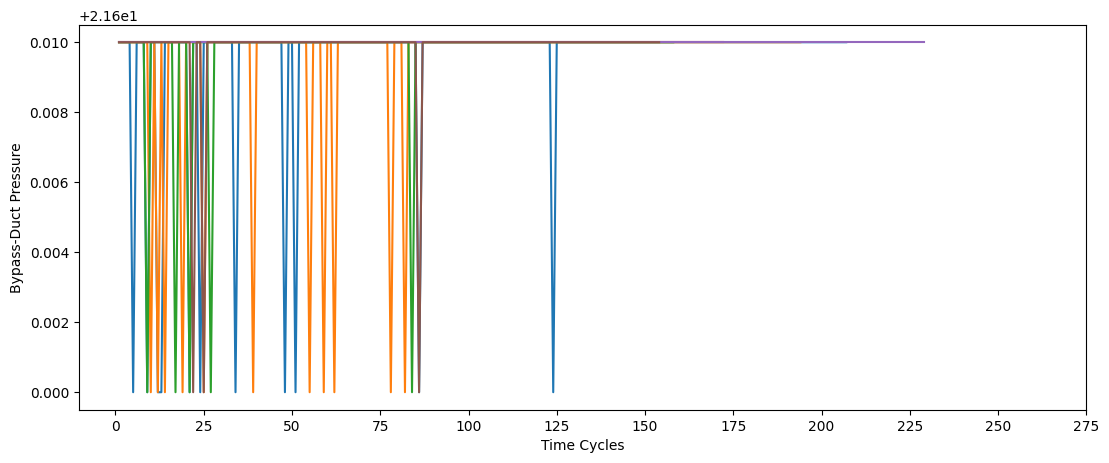

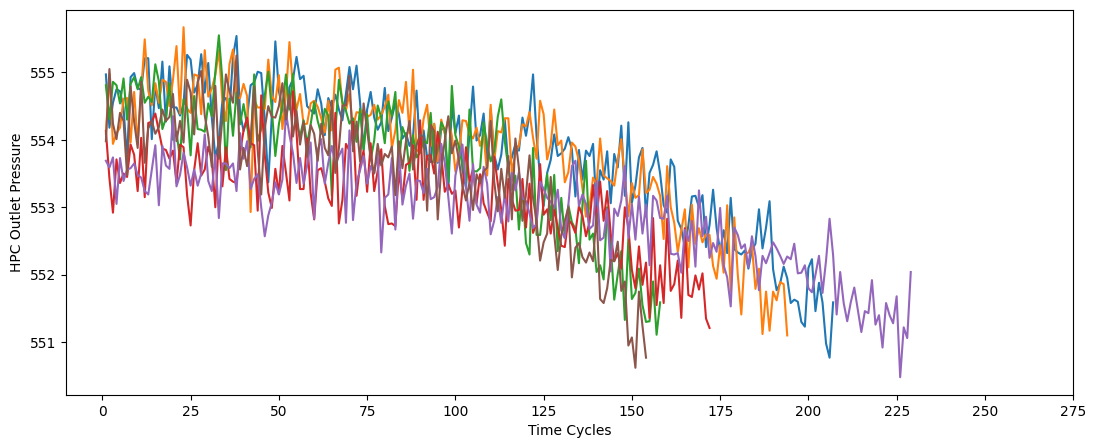

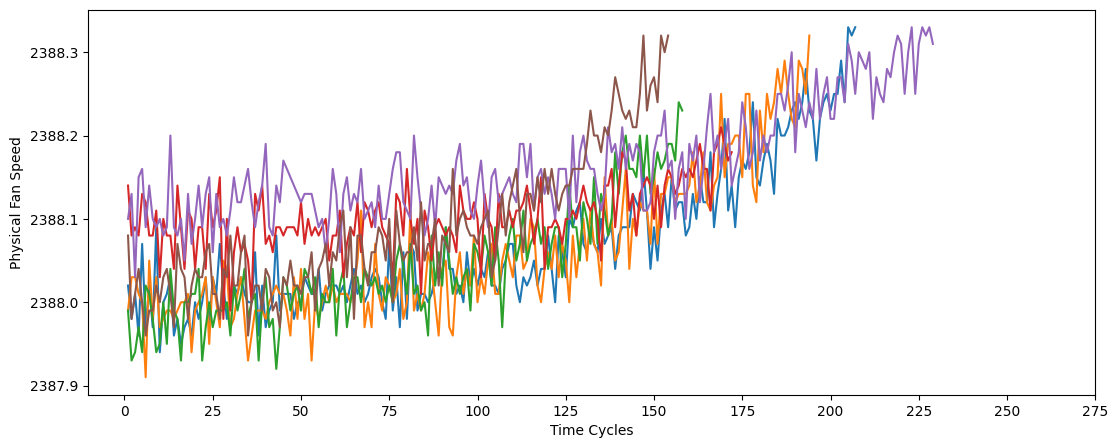

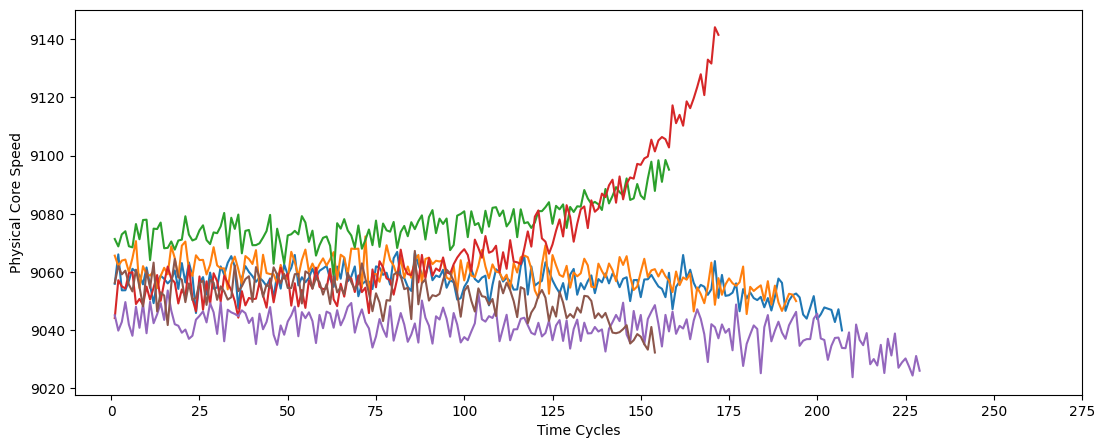

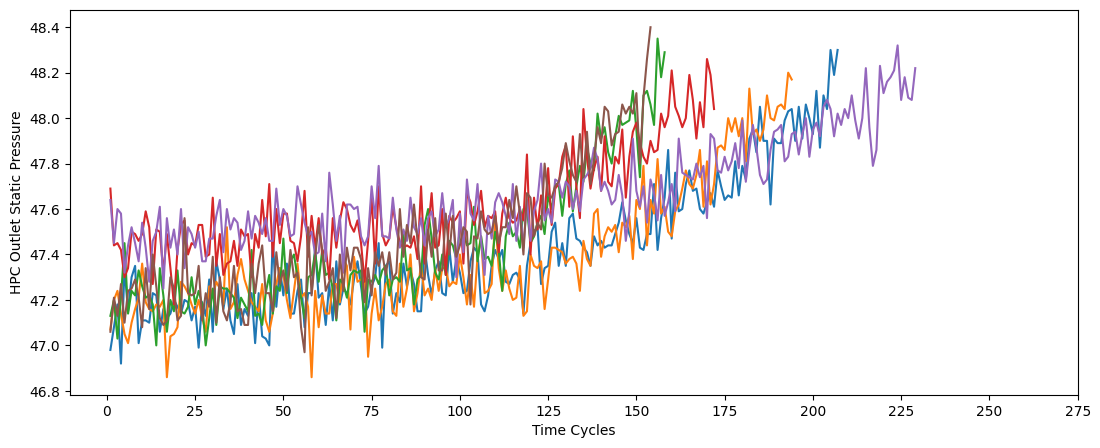

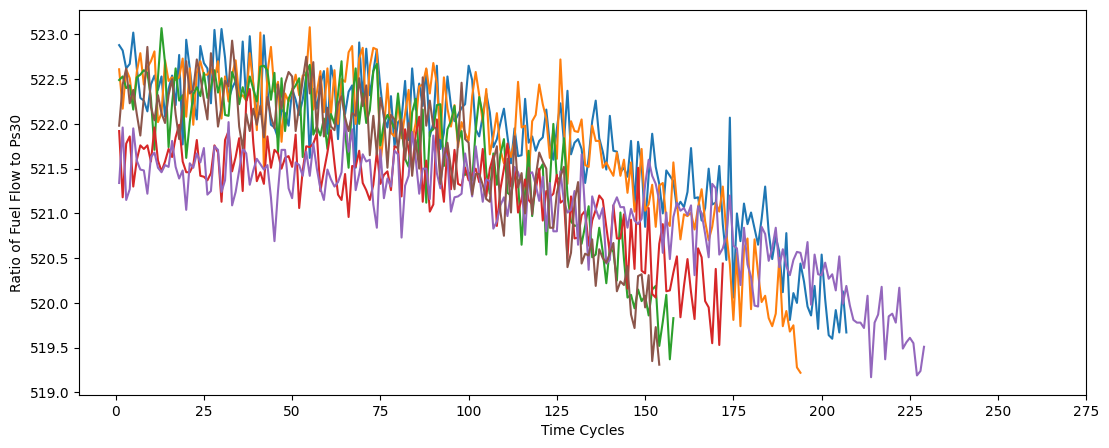

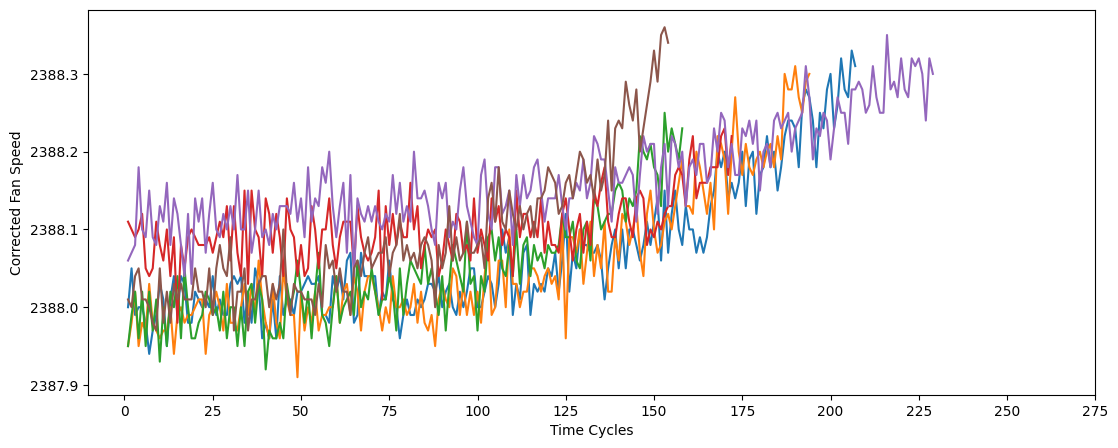

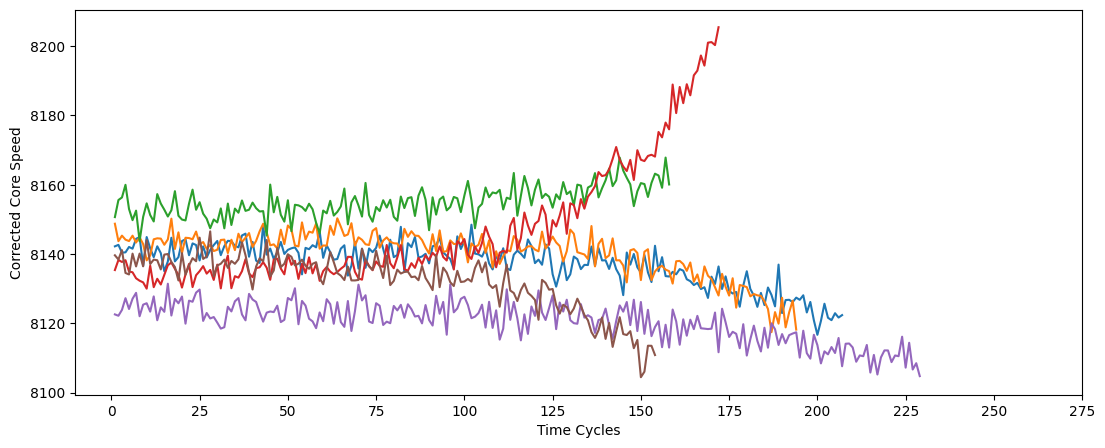

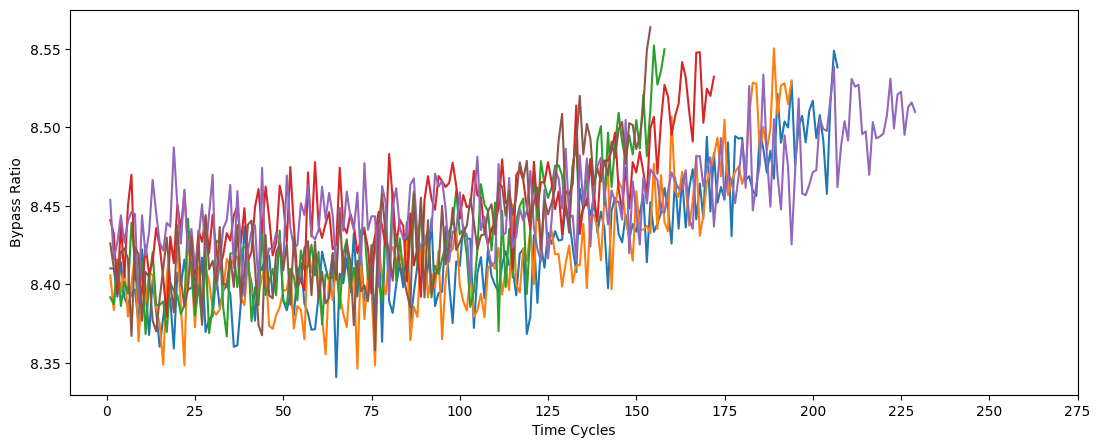

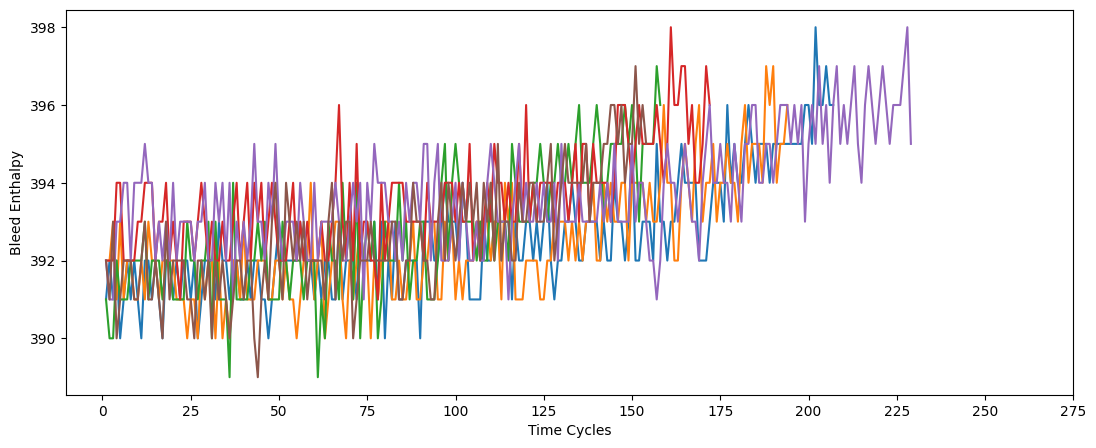

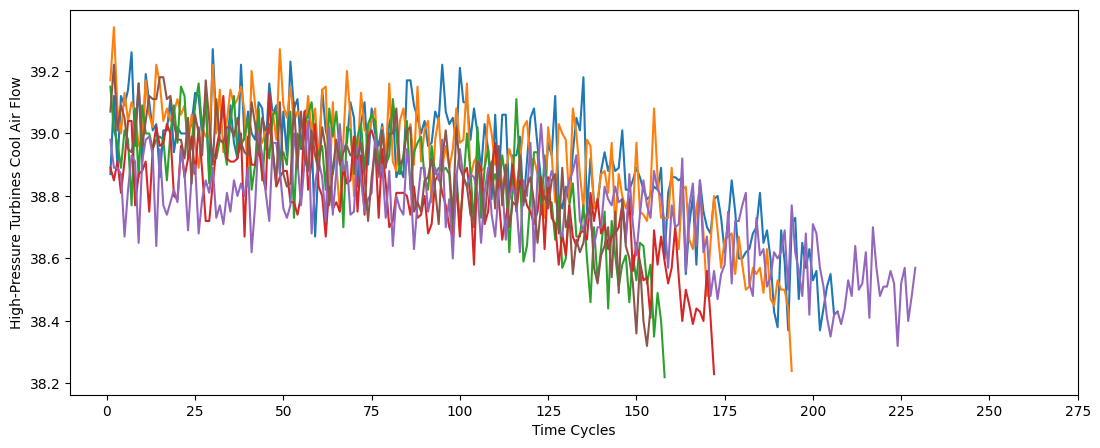

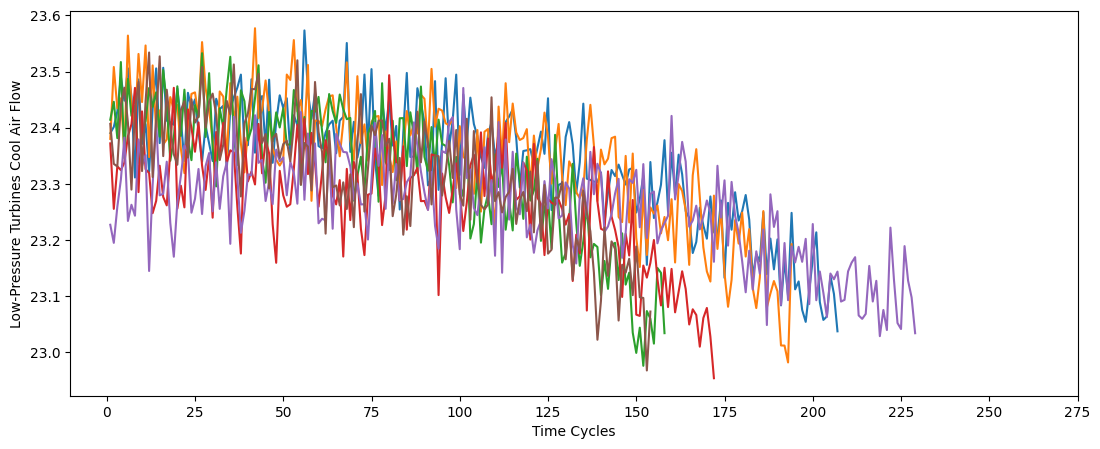

In [86]:
features = [col for col in train.columns if col not in ['time_cycles', 'unit_number']]
for feature in features:
    plt.figure(figsize=(13,5))

    for i in train['unit_number'].unique():
        if (i % 15 == 0):
            plt.plot('time_cycles', feature, data=train[train['unit_number']==i])

    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(feature)
    plt.xlabel('Time Cycles')
    plt.show()


We can visualize a general trend in most features before the engine reaches failure. The Bypass-Duc Pressure will be another feature we'll drop, while it does have data, it doesn't tell us anything. A similar stance can be said for setting_1, setting_2. Physical Core Speed and corrected Core Speed, while there looks to be an individual trend, we can expect a weaker correlation to Time Cycles.

In [87]:
trainf = train.drop(columns=['setting_1', 'setting_2', 'Bypass-Duct Pressure'])

## Feature Engineering

While the features we currently have do follow a clear trend until the engine reaches failure, we need a few more. The more important feature we need to train with is the Remaining Useful Lifecycles.

Afterwards, we'll create Moving Averages and Exponential Moving Averages of each feature so we can look more at the trend and work with less "noise".

Finally, if there is a significant distance between Stable levels and Failure Levels, having features that measure the distance from each will be useful.

In [88]:
RUL = trainf.groupby('unit_number')['time_cycles'].apply(lambda x: x.max() - x + 1)
RUL = RUL.reset_index(level=0, drop=True)
trainf['RUL'] = RUL

In [89]:
features = [col for col in trainf.columns if col not in ['unit_number', 'time_cycles', 'RUL']]

train_ma = trainf.copy()

ma_window = 20
ema_window = 16

for feature in features:
    feat_ma = str(feature) + '_ma'
    feat_ema = str(feature) + '_ema'
    ma_list = []
    ema_list = []
      
    for unit in range(1, 101):
        ma = train_ma[train_ma['unit_number'] == unit][feature].rolling(ma_window).mean()
        ema = train_ma[train_ma['unit_number'] == unit][feature].ewm(span=ema_window, adjust=False, min_periods=ema_window).mean()

        ma_list.append(ma)
        ema_list.append(ema)

    ma_list = pd.concat(ma_list).to_list()
    ema_list = pd.concat(ema_list).to_list()

    unit_index = train_ma.columns.get_loc(feature)
    train_ma.insert(unit_index+1, feat_ema, ema_list)
    train_ma.insert(unit_index+1, feat_ma, ma_list)

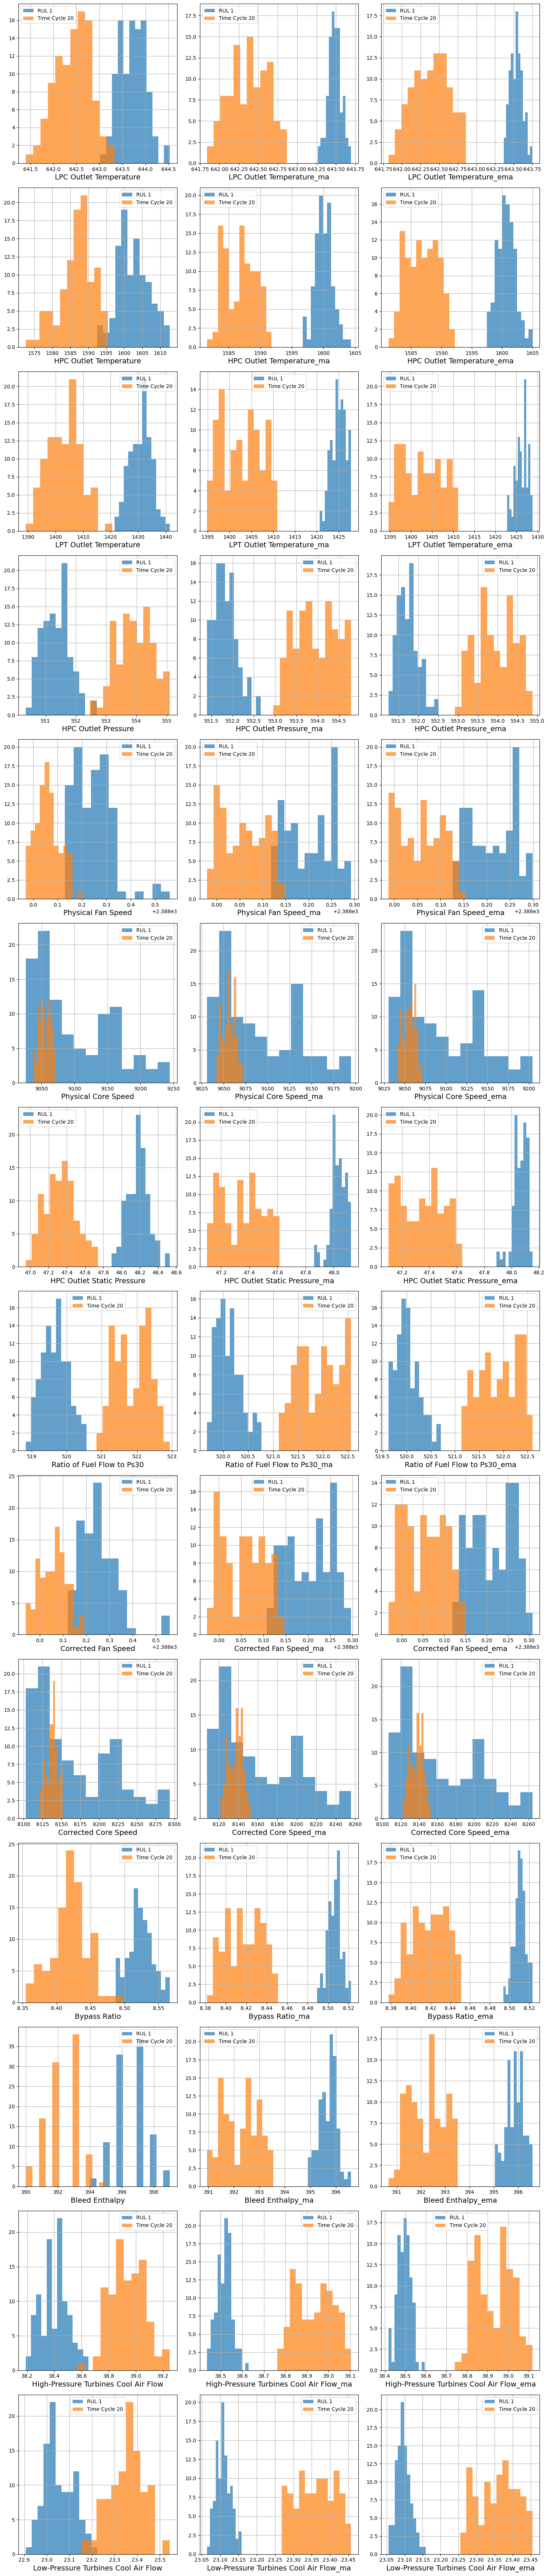

In [90]:
features = [col for col in train_ma.columns if col not in ['unit_number', 'time_cycles', 'RUL']]
bin_num = 12

ma_window = 20
ema_window = 16
count = 0

row = int(len(features)/3)
fig, axes = plt.subplots(row, 3, figsize=(15, 5 * row))
for feature in features:
    row_index = count // 3
    col_index = count % 3

    ax = axes[row_index, col_index]
    ax.set_xlabel(feature, fontsize=14)

    train_ma[train_ma['RUL'] == 1][feature].hist(bins=bin_num, alpha=0.7, label='RUL 1', ax=ax)
    train_ma[train_ma['time_cycles'] == ma_window][feature].hist(bins=bin_num, alpha=0.7, label='Time Cycle %s' % ma_window, ax=ax)

    ax.legend()
    count += 1

plt.tight_layout()
plt.show()


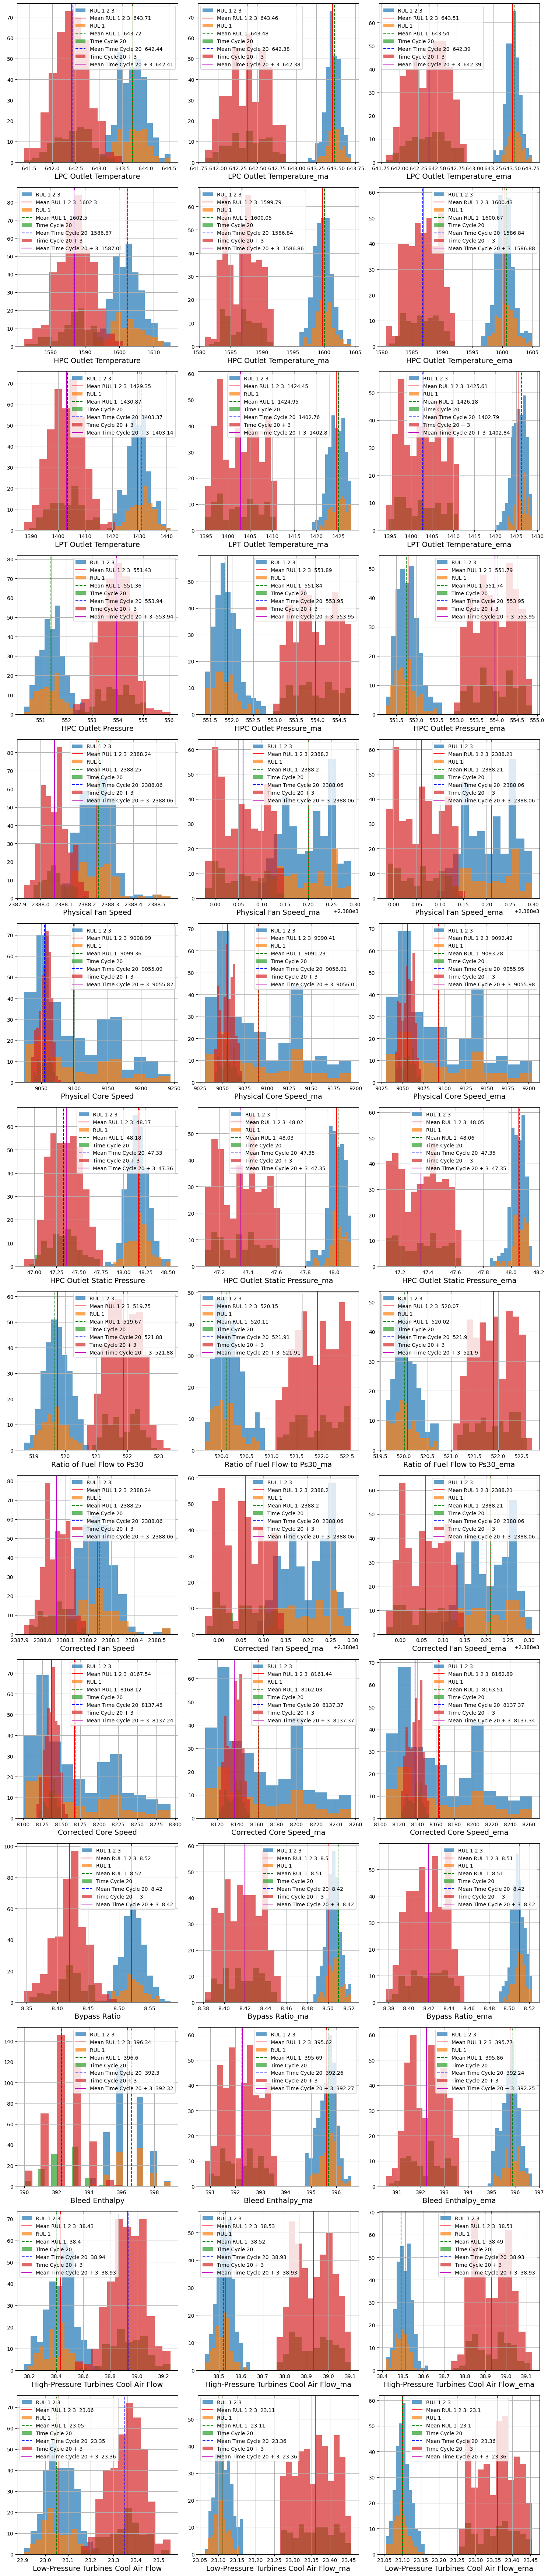

In [91]:
features = [col for col in train_ma.columns if col not in ['unit_number', 'time_cycles', 'RUL']]

bin_num = 12
ma_window = 20
ema_window = 16
count = 0

row = int(len(features)/3)
fig, axes = plt.subplots(row, 3, figsize=(15, 5 * row))

for feature in features:
    row_index = count // 3
    col_index = count % 3

    ax = axes[row_index, col_index]
    ax.set_xlabel(feature, fontsize=14)

    train_ma[train_ma['RUL'] <= 3][feature].hist(bins=bin_num, alpha=0.7, label='RUL 1 2 3', ax=ax)
    mean_rul_123 = train_ma[train_ma['RUL'] <= 3][feature].mean().round(2)
    ax.axvline(x=mean_rul_123, color='r', linestyle='solid', label='Mean RUL 1 2 3  %s' % mean_rul_123)

    train_ma[train_ma['RUL'] == 1][feature].hist(bins=bin_num, alpha=0.7, label='RUL 1', ax=ax)
    mean_rul_1 = train_ma[train_ma['RUL'] == 1][feature].mean().round(2)
    ax.axvline(x=mean_rul_1, color='g', linestyle='--', label='Mean RUL 1  %s' % mean_rul_1)

    train_ma[train_ma['time_cycles'] == ma_window][feature].hist(bins=bin_num, alpha=0.7, label='Time Cycle %s' % ma_window, ax=ax)
    mean_ma_window = train_ma[train_ma['time_cycles'] == ma_window][feature].mean().round(2)
    ax.axvline(x=mean_ma_window, color='b', linestyle='--', label='Mean Time Cycle %s  %s' % (ma_window, mean_ma_window))

    train_ma[(ma_window <= train_ma['time_cycles']) & (train_ma['time_cycles'] <= (ma_window+3))][feature].hist(bins=bin_num, alpha=0.7, label='Time Cycle %s + 3' % ma_window, ax=ax)
    mean_ma_window_plus_3 = train_ma[(ma_window <= train_ma['time_cycles']) & (train_ma['time_cycles'] <= (ma_window+3))][feature].mean().round(2)
    ax.axvline(x=mean_ma_window_plus_3, color='m', linestyle='solid', label='Mean Time Cycle %s + 3  %s' % (ma_window, mean_ma_window_plus_3))

    ax.legend()
    count += 1

plt.tight_layout()
plt.show()


The purpose of the graph was to ensure the next feature I make is worthwhile. There is a clear difference between a features beginning value and value before failure. Tracking how close the feature is these two values may provide to be useful.

It's clear that there are some features that don't show as clear of a difference between the it values early in its cycle versus right at failure.

Looking at the means, we can see a smaller gap between the plotted RUL and its respective Time Cycle for the Moving average and Exponential Moving Average histograms.

In [92]:
train_ma

unit_number  time_cycles  LPC Outlet Temperature  \
0                1            1                  641.82   
1                1            2                  642.15   
2                1            3                  642.35   
3                1            4                  642.35   
4                1            5                  642.37   
...            ...          ...                     ...   
20626          100          196                  643.49   
20627          100          197                  643.54   
20628          100          198                  643.42   
20629          100          199                  643.23   
20630          100          200                  643.85   

       LPC Outlet Temperature_ma  LPC Outlet Temperature_ema  \
0                            NaN                         NaN   
1                            NaN                         NaN   
2                            NaN                         NaN   
3                            NaN                         NaN   
4                            NaN                         NaN   
...                          ...                         ...   
20626                   643.4160                  643.418948   
20627                   643.4260                  643.433189   
20628                   643.4480                  643.431638   
20629                   643.4485                  643.407916   
20630                   643.4590                  643.459926   

       HPC Outlet Temperature  HPC Outlet Temperature_ma  \
0                     1589.70                        NaN   
1                     1591.82                        NaN   
2                     1587.99                        NaN   
3                     1582.79                        NaN   
4                     1582.85                        NaN   
...                       ...                        ...   
20626                 1597.98                  1598.4795   
20627                 1604.50                  1599.0435   
20628                 1602.46                  1599.4265   
20629                 1605.26                  1599.7215   
20630                 1600.38                  1599.9415   

       HPC Outlet Temperature_ema  LPT Outlet Temperature  \
0                             NaN                 1400.60   
1                             NaN                 1403.14   
2                             NaN                 1404.20   
3                             NaN                 1401.87   
4                             NaN                 1406.22   
...                           ...                     ...   
20626                 1599.039656                 1428.63   
20627                 1599.682049                 1433.58   
20628                 1600.008867                 1428.18   
20629                 1600.626647                 1426.53   
20630                 1600.597630                 1432.14   

       LPT Outlet Temperature_ma  LPT Outlet Temperature_ema  \
0                            NaN                         NaN   
1                            NaN                         NaN   
2                            NaN                         NaN   
3                            NaN                         NaN   
4                            NaN                         NaN   
...                          ...                         ...   
20626                  1423.4480                 1425.172483   
20627                  1424.1815                 1426.161603   
20628                  1424.4560                 1426.399061   
20629                  1424.5855                 1426.414466   
20630                  1425.3700                 1427.088058   

       HPC Outlet Pressure  HPC Outlet Pressure_ma  HPC Outlet Pressure_ema  \
0                   554.36                     NaN                      NaN   
1                   553.75                     NaN                      NaN   
2                   554.26                     NaN                   

In [93]:
features = [col for col in train_ma.columns if col not in ['unit_number', 'time_cycles', 'RUL']]

train_dif = train_ma.copy()

ma_window = 20
ema_window = 16

for feature in features:
    feat_s = str(feature) + ' dist. from Stable'
    feat_f = str(feature) + ' dist. from Failure'
    s_list = []
    f_list = []
      
    for unit in range(1, 101):
        ma = train_dif[train_dif['unit_number'] == unit][feature].rolling(ma_window).mean()
        ema = train_dif[train_dif['unit_number'] == unit][feature].ewm(span=ema_window, adjust=False, min_periods=ema_window).mean()
        mean_failure = train_dif[train_dif['RUL'] == 1][feature].mean().round(2)
        mean_stable = train_dif[train_dif['time_cycles'] == ma_window][feature].mean().round(2)

        if mean_stable > mean_failure:
            s_dif = mean_stable - train_dif[train_dif['unit_number'] == unit][feature]
            f_dif = train_dif[train_dif['unit_number'] == unit][feature] - mean_failure
        else:
            s_dif = train_dif[train_dif['unit_number'] == unit][feature] - mean_stable
            f_dif = mean_failure - train_dif[train_dif['unit_number'] == unit][feature]


        s_list.append(s_dif)
        f_list.append(f_dif)

    s_list = pd.concat(s_list).to_list()
    f_list = pd.concat(f_list).to_list()

    unit_index = train_dif.columns.get_loc(feature)
    train_dif.insert(unit_index+1, feat_s, s_list)
    train_dif.insert(unit_index+1, feat_f, f_list)

We now run into the problem of our difference from failure/stable having values that are beyond failure or below stable. Any negative values will be set to 0.

In [94]:
features = [col for col in train_dif.columns if col not in ['unit_number', 'time_cycles', 'RUL'] and 'Failure' in col]
train_diff = train_dif.copy()

for feature in features:
    train_diff[feature].mask(train_diff[feature] < 0, 0, inplace=True)

In [95]:
train_diff

unit_number  time_cycles  LPC Outlet Temperature  \
0                1            1                  641.82   
1                1            2                  642.15   
2                1            3                  642.35   
3                1            4                  642.35   
4                1            5                  642.37   
...            ...          ...                     ...   
20626          100          196                  643.49   
20627          100          197                  643.54   
20628          100          198                  643.42   
20629          100          199                  643.23   
20630          100          200                  643.85   

       LPC Outlet Temperature dist. from Failure  \
0                                           1.90   
1                                           1.57   
2                                           1.37   
3                                           1.37   
4                                           1.35   
...                                          ...   
20626                                       0.23   
20627                                       0.18   
20628                                       0.30   
20629                                       0.49   
20630                                       0.00   

       LPC Outlet Temperature dist. from Stable  LPC Outlet Temperature_ma  \
0                                         -0.62                        NaN   
1                                         -0.29                        NaN   
2                                         -0.09                        NaN   
3                                         -0.09                        NaN   
4                                         -0.07                        NaN   
...                                         ...                        ...   
20626                                      1.05                   643.4160   
20627                                      1.10                   643.4260   
20628                                      0.98                   643.4480   
20629                                      0.79                   643.4485   
20630                                      1.41                   643.4590   

       LPC Outlet Temperature_ma dist. from Failure  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
20626                                        0.0640   
20627                                        0.0540   
20628                                        0.0320   
20629                                        0.0315   
20630                                        0.0210   

       LPC Outlet Temperature_ma dist. from Stable  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
20626                                       1.0360   
20627                                       1.0460   
20628                                       1.0680   
20629                                       1.0685   
20630                                       1.0790   

       LPC Outlet Temperature_ema  \
0                             NaN   
1                             NaN   
2                             NaN   
3                             NaN   
4                             NaN   
...                           ...   
20626                  643.418948   
20627                  643.433189   
20628                  643.431638   
20629                  643.407916   
20630              

After creating our extra features, lets visualize the correlation between them and RUL

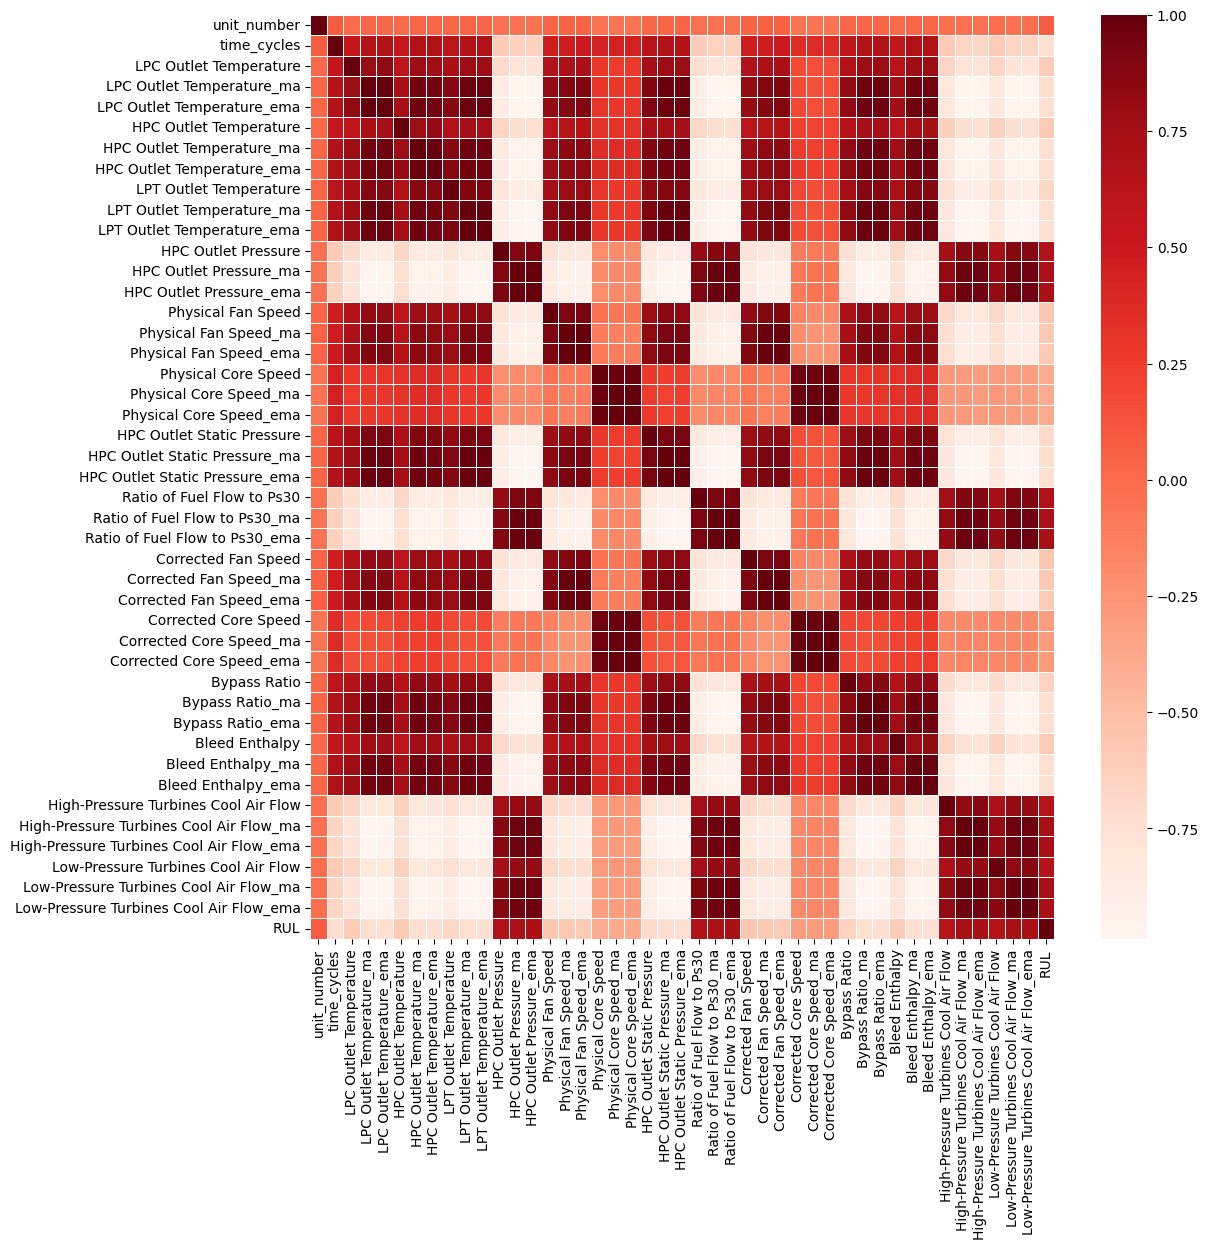

In [96]:
columns_to_exclude = [col for col in train_diff.columns if 'dist' in col]
corr = train_diff.drop(columns=columns_to_exclude).corr()


plt.figure(figsize=(12,12))
sns.heatmap(corr, fmt=".2f", linewidths=0.4, annot_kws={'size': 14}, cmap="Reds")
plt.show()

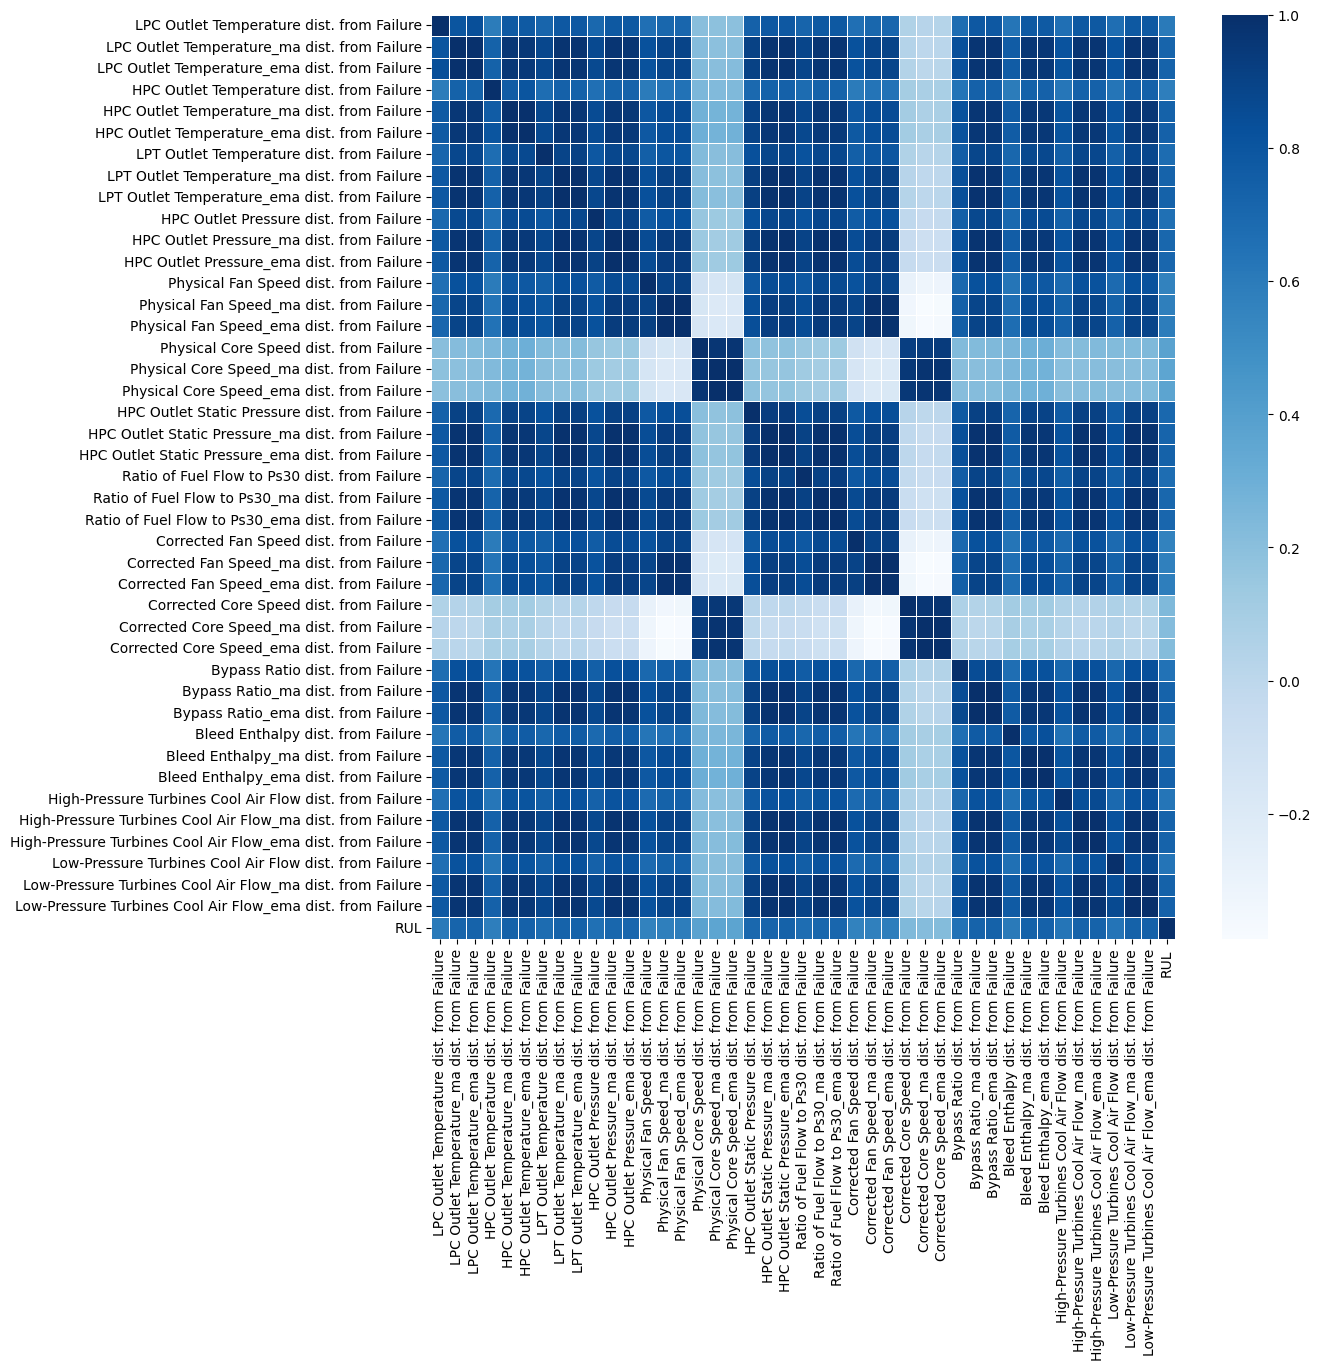

In [97]:
columns_to_exclude = [col for col in train_diff.columns if 'dist. from Failure' not in col and 'RUL' not in col]
corr = train_diff.drop(columns=columns_to_exclude).corr()


plt.figure(figsize=(12,12))
sns.heatmap(corr, fmt=".2f", linewidths=0.4, annot_kws={'size': 14}, cmap="Blues")
plt.show()

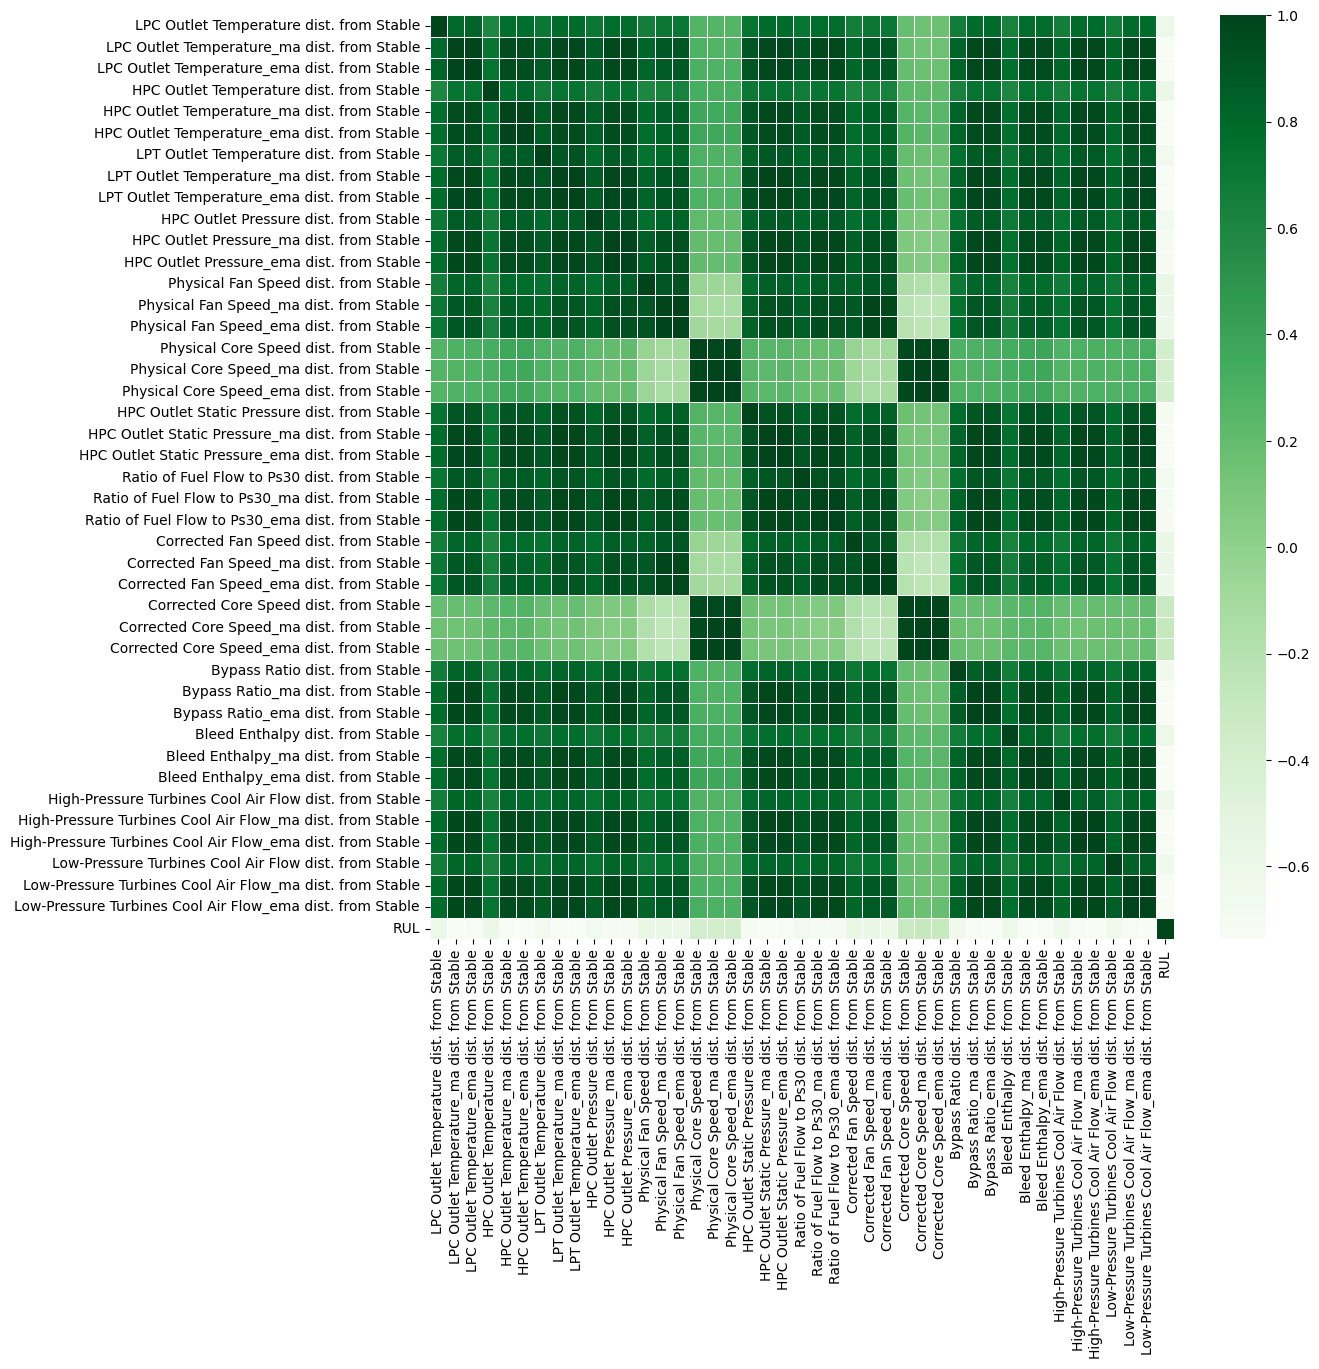

In [98]:
columns_to_exclude = [col for col in train_diff.columns if 'dist. from Stable' not in col and 'RUL' not in col]
corr = train_diff.drop(columns=columns_to_exclude).corr()


plt.figure(figsize=(12,12))
sns.heatmap(corr, fmt=".2f", linewidths=0.4, annot_kws={'size': 14}, cmap="Greens")
plt.show()

In [99]:
rul_corr = train_diff.corr(method='pearson')['RUL'].round(4).abs().sort_values(ascending=False)
for feature, correlation in rul_corr.items():
    print(f"{feature} {correlation}")

RUL 1.0
Bleed Enthalpy_ema dist. from Failure 0.7378
Bleed Enthalpy_ema dist. from Stable 0.737
Bleed Enthalpy_ema 0.737
time_cycles 0.7362
HPC Outlet Temperature_ema dist. from Failure 0.736
Low-Pressure Turbines Cool Air Flow_ema dist. from Failure 0.735
HPC Outlet Temperature_ema 0.7347
HPC Outlet Temperature_ema dist. from Stable 0.7347
Low-Pressure Turbines Cool Air Flow_ema dist. from Stable 0.7343
Low-Pressure Turbines Cool Air Flow_ema 0.7343
LPT Outlet Temperature_ema dist. from Failure 0.7336
LPT Outlet Temperature_ema 0.7333
LPT Outlet Temperature_ema dist. from Stable 0.7333
Bleed Enthalpy_ma dist. from Failure 0.7329
Bypass Ratio_ema dist. from Failure 0.7325
HPC Outlet Temperature_ma dist. from Failure 0.7323
Bleed Enthalpy_ma 0.7321
Bleed Enthalpy_ma dist. from Stable 0.7321
Bypass Ratio_ema dist. from Stable 0.732
Bypass Ratio_ema 0.732
HPC Outlet Temperature_ma 0.7311
HPC Outlet Temperature_ma dist. from Stable 0.7311
Low-Pressure Turbines Cool Air Flow_ma dist. from F

In [100]:
# dataset with only features that are 0.7 or above correlated

corr70_list = rul_corr[rul_corr > 0.7].index.tolist()

include_list = ['unit_number', 'time_cycles']

for x in include_list:
    if x not in corr70_list:
        corr70_list.append(x)

train_70 = train_diff[corr70_list]

In [101]:
train_cap = train_70.copy()

train_cap.loc[train_cap['RUL'] > 120, 'RUL'] = 120

In [102]:
train_rul = train.copy()
RUL = train.groupby('unit_number')['time_cycles'].apply(lambda x: x.max() - x + 1)
RUL = RUL.reset_index(level=0, drop=True)
train_rul['RUL'] = RUL

In [103]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)
    print('{} set RMSE: {}, R2: {}'.format(label, round(rmse, 2), round(r2, 4)))

In [104]:
test_diff = test[trainf.drop(columns=['RUL']).columns]
features = [col for col in test_diff.columns if col not in ['unit_number', 'time_cycles']]

ma_window = 20
ema_window = 16

for feature in features:
    feat_ma = str(feature) + '_ma'
    feat_ema = str(feature) + '_ema'
    ma_list = []
    ema_list = []
      
    for unit in range(1, 101):
        ma = test_diff[test_diff['unit_number'] == unit][feature].rolling(ma_window).mean()
        ema = test_diff[test_diff['unit_number'] == unit][feature].ewm(span=ema_window, adjust=False, min_periods=ema_window).mean()

        ma_list.append(ma)
        ema_list.append(ema)

    ma_list = pd.concat(ma_list).to_list()
    ema_list = pd.concat(ema_list).to_list()

    unit_index = test_diff.columns.get_loc(feature)
    test_diff.insert(unit_index+1, feat_ema, ema_list)
    test_diff.insert(unit_index+1, feat_ma, ma_list)

In [105]:
features = [col for col in test_diff.columns if col not in ['unit_number', 'time_cycles']]

ma_window = 20
ema_window = 16

for feature in features:
    feat_s = str(feature) + ' dist. from Stable'
    feat_f = str(feature) + ' dist. from Failure'
    s_list = []
    f_list = []
      
    for unit in range(1, 101):
        ma = test_diff[test_diff['unit_number'] == unit][feature].rolling(ma_window).mean()
        ema = test_diff[test_diff['unit_number'] == unit][feature].ewm(span=ema_window, adjust=False, min_periods=ema_window).mean()
        mean_failure = train_diff[train_diff['RUL'] == 1][feature].mean().round(2)
        mean_stable = train_diff[train_diff['time_cycles'] == ma_window][feature].mean().round(2)

        if mean_stable > mean_failure:
            s_dif = mean_stable - test_diff[test_diff['unit_number'] == unit][feature]
            f_dif = test_diff[test_diff['unit_number'] == unit][feature] - mean_failure
        else:
            s_dif = test_diff[test_diff['unit_number'] == unit][feature] - mean_stable
            f_dif = mean_failure - test_diff[test_diff['unit_number'] == unit][feature]


        s_list.append(s_dif)
        f_list.append(f_dif)

    s_list = pd.concat(s_list).to_list()
    f_list = pd.concat(f_list).to_list()

    unit_index = test_diff.columns.get_loc(feature)
    test_diff.insert(unit_index+1, feat_s, s_list)
    test_diff.insert(unit_index+1, feat_f, f_list)

In [106]:
print(test_diff.shape)
print(train_diff.shape)

(13096, 128)
(20631, 129)


In [107]:
train_diff

unit_number  time_cycles  LPC Outlet Temperature  \
0                1            1                  641.82   
1                1            2                  642.15   
2                1            3                  642.35   
3                1            4                  642.35   
4                1            5                  642.37   
...            ...          ...                     ...   
20626          100          196                  643.49   
20627          100          197                  643.54   
20628          100          198                  643.42   
20629          100          199                  643.23   
20630          100          200                  643.85   

       LPC Outlet Temperature dist. from Failure  \
0                                           1.90   
1                                           1.57   
2                                           1.37   
3                                           1.37   
4                                           1.35   
...                                          ...   
20626                                       0.23   
20627                                       0.18   
20628                                       0.30   
20629                                       0.49   
20630                                       0.00   

       LPC Outlet Temperature dist. from Stable  LPC Outlet Temperature_ma  \
0                                         -0.62                        NaN   
1                                         -0.29                        NaN   
2                                         -0.09                        NaN   
3                                         -0.09                        NaN   
4                                         -0.07                        NaN   
...                                         ...                        ...   
20626                                      1.05                   643.4160   
20627                                      1.10                   643.4260   
20628                                      0.98                   643.4480   
20629                                      0.79                   643.4485   
20630                                      1.41                   643.4590   

       LPC Outlet Temperature_ma dist. from Failure  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
20626                                        0.0640   
20627                                        0.0540   
20628                                        0.0320   
20629                                        0.0315   
20630                                        0.0210   

       LPC Outlet Temperature_ma dist. from Stable  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
20626                                       1.0360   
20627                                       1.0460   
20628                                       1.0680   
20629                                       1.0685   
20630                                       1.0790   

       LPC Outlet Temperature_ema  \
0                             NaN   
1                             NaN   
2                             NaN   
3                             NaN   
4                             NaN   
...                           ...   
20626                  643.418948   
20627                  643.433189   
20628                  643.431638   
20629                  643.407916   
20630              

In [108]:
test_diff

unit_number  time_cycles  LPC Outlet Temperature  \
0                1            1                  643.02   
1                1            2                  641.71   
2                1            3                  642.46   
3                1            4                  642.44   
4                1            5                  642.51   
...            ...          ...                     ...   
13091          100          194                  643.24   
13092          100          195                  643.22   
13093          100          196                  643.44   
13094          100          197                  643.26   
13095          100          198                  642.95   

       LPC Outlet Temperature dist. from Failure  \
0                                           0.70   
1                                           2.01   
2                                           1.26   
3                                           1.28   
4                                           1.21   
...                                          ...   
13091                                       0.48   
13092                                       0.50   
13093                                       0.28   
13094                                       0.46   
13095                                       0.77   

       LPC Outlet Temperature dist. from Stable  LPC Outlet Temperature_ma  \
0                                          0.58                        NaN   
1                                         -0.73                        NaN   
2                                          0.02                        NaN   
3                                          0.00                        NaN   
4                                          0.07                        NaN   
...                                         ...                        ...   
13091                                      0.80                   642.8085   
13092                                      0.78                   642.8570   
13093                                      1.00                   642.8925   
13094                                      0.82                   642.9155   
13095                                      0.51                   642.9470   

       LPC Outlet Temperature_ma dist. from Failure  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
13091                                        0.6715   
13092                                        0.6230   
13093                                        0.5875   
13094                                        0.5645   
13095                                        0.5330   

       LPC Outlet Temperature_ma dist. from Stable  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
...                                            ...   
13091                                       0.4285   
13092                                       0.4770   
13093                                       0.5125   
13094                                       0.5355   
13095                                       0.5670   

       LPC Outlet Temperature_ema  \
0                             NaN   
1                             NaN   
2                             NaN   
3                             NaN   
4                             NaN   
...                           ...   
13091                  642.940445   
13092                  642.973334   
13093                  643.028236   
13094                  643.055502   
13095              

## Begin modeling and predictions for our datasets.

First we'll run predictions on our data will all the MA, EMA, and Differences features. Afterwards we'll run our predictions when we limit our data to ones that are 0.7 correlated and above, and then capping the RUL at 120.

In [109]:
# Start by splitting and then standardizing all of our datasets, followed by a logistic regression fit
scaler = MinMaxScaler()
lr = LinearRegression()

train_diff = train_diff.fillna(method='backfill')
test_diff = test_diff.fillna(method='backfill')

X_diff = train_diff.drop(columns=['RUL'])
Y_diff = train_diff['RUL']
X_train_diff, X_test_diff, Y_train_diff, Y_test_diff = train_test_split(X_diff, Y_diff, test_size = 0.3, random_state=42)

scaler.fit(X_train_diff)
X_train_diff_s = scaler.transform(X_train_diff)
X_test_diff_s = scaler.transform(X_test_diff)
test_diff_s = scaler.transform(test_diff)

lr.fit(X=X_train_diff_s, y=Y_train_diff)
y_lr_train_diff = lr.predict(X_train_diff_s)
y_lr_test_diff = lr.predict(X_test_diff_s)
y_lr_test_valid_diff = lr.predict(test_diff_s)

# here we are creating an RUL column for our test file, and we're filling it
# with our RUL predictions. We'll then collect the last RUL value for each
# unit and evaluate it against our Valid file which contains the true RUL values
test_diff['RUL_pred'] = y_lr_test_valid_diff.round()
test_diff_pred = test_diff.groupby('unit_number').last().reset_index()

evaluate(y_lr_train_diff, Y_train_diff, label='train')
evaluate(y_lr_test_diff, Y_test_diff, label='test')
evaluate(test_diff_pred['RUL_pred'], valid, label='valid')

train set RMSE: 37.75, R2: 0.5791
test set RMSE: 37.29, R2: 0.5812
valid set RMSE: 31.89, R2: 0.6547


In [110]:
if 'RUL' in corr70_list:
    corr70_list.remove('RUL')
test_70 = test_diff[corr70_list]


In [111]:

# Start by splitting and then standardizing all of our datasets, followed by a logistic regression fit
scaler = MinMaxScaler()
lr = LinearRegression()

train_70 = train_70.fillna(method='backfill')
test_70 = test_70.fillna(method='backfill')


X_70 = train_70.drop(columns=['RUL'])
Y_70 = train_70['RUL']
X_train_70, X_test_70, Y_train_70, Y_test_70 = train_test_split(X_70, Y_70, test_size = 0.3, random_state= 42)

scaler.fit(X_train_70)
X_train_70_s = scaler.transform(X_train_70)
X_test_70_s = scaler.transform(X_test_70)
test_70_s = scaler.transform(test_70)

lr.fit(X=X_train_70_s, y=Y_train_70)
y_lr_train_70 = lr.predict(X_train_70_s)
y_lr_test_70 = lr.predict(X_test_70_s)
y_lr_test_valid_70 = lr.predict(test_70_s)

# here we are creating an RUL column for our test file, and we're filling it
# with our RUL predictions. We'll then collect the last RUL value for each
# unit and evaluate it against our Valid file which contains the true RUL values
test_70['RUL_pred'] = y_lr_test_valid_70.round()
test_70_pred = test_70.groupby('unit_number').last().reset_index()

evaluate(y_lr_train_70, Y_train_70, label='train')
evaluate(y_lr_test_70, Y_test_70, label='test')
evaluate(test_70_pred['RUL_pred'], valid, label='valid')

train set RMSE: 38.69, R2: 0.5552
test set RMSE: 37.96, R2: 0.5627
valid set RMSE: 32.6, R2: 0.5919


In [112]:
test_70_pred['RUL true'] = valid
test_70_pred[['RUL true', 'RUL_pred']]

RUL true  RUL_pred
0        112     157.0
1         98     126.0
2         69      60.0
3         82      81.0
4         91      94.0
..       ...       ...
95       137     161.0
96        82     130.0
97        59     104.0
98       117     152.0
99        20      24.0

[100 rows x 2 columns]

In [113]:

# Start by splitting and then standardizing all of our datasets, followed by a logistic regression fit
scaler = MinMaxScaler()
lr = LinearRegression()

train_cap = train_cap.fillna(method='backfill')
test_70 = test_70.fillna(method='backfill').drop(columns=['RUL_pred'])


X_cap = train_cap.drop(columns=['RUL'])
Y_cap = train_cap['RUL']
X_train_cap, X_test_70, Y_train_cap, Y_test_70 = train_test_split(X_cap, Y_cap, test_size = 0.3, random_state= 42)

scaler.fit(X_train_cap)
X_train_cap_s = scaler.transform(X_train_cap)
X_test_70_s = scaler.transform(X_test_70)
test_70_s = scaler.transform(test_70)

lr.fit(X=X_train_cap_s, y=Y_train_cap)
y_lr_train_cap = lr.predict(X_train_cap_s)
y_lr_test_70 = lr.predict(X_test_70_s)
y_lr_test_valid_cap = lr.predict(test_70_s)

test_70['RUL_pred'] = y_lr_test_valid_cap.round()
test_70_pred = test_70.groupby('unit_number').last().reset_index()

evaluate(y_lr_train_cap, Y_train_cap, label='train')
evaluate(y_lr_test_70, Y_test_70, label='test')
evaluate(test_70_pred['RUL_pred'], valid, label='valid')

train set RMSE: 17.75, R2: 0.7492
test set RMSE: 17.63, R2: 0.7437
valid set RMSE: 21.42, R2: 0.559


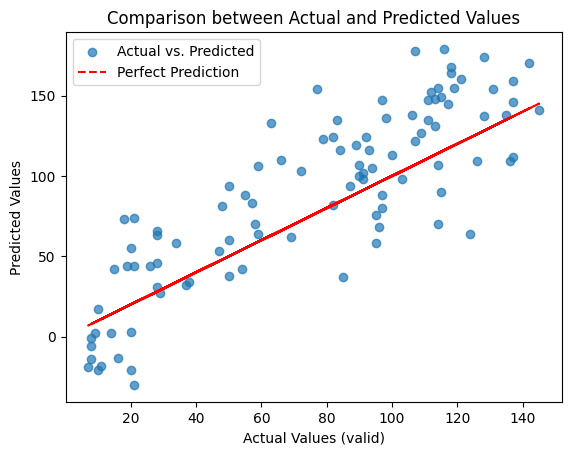

In [114]:
plt.scatter(valid, test_diff_pred['RUL_pred'], label="Actual vs. Predicted", alpha=0.7)
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

Now lets run a SVR model on our full dataset and again on our capped dataset.

In [115]:
svr = SVR(kernel='rbf')

train_diff = train_diff.fillna(method='backfill')
if 'RUL_pred' in test_diff.columns:
    test_diff = test_diff.drop(columns=['RUL_pred'])
test_diff = test_diff.fillna(method='backfill')

X_diff = train_diff.drop(columns=['RUL'])
Y_diff = train_diff['RUL']
X_train_diff, X_test_diff, Y_train_diff, Y_test_diff = train_test_split(X_diff, Y_diff, test_size = 0.3, random_state= 42)

scaler.fit(X_train_diff)
X_train_diff_s = scaler.transform(X_train_diff)
X_test_diff_s = scaler.transform(X_test_diff)
test_diff_s = scaler.transform(test_diff)

svr.fit(X_train_diff_s, Y_train_diff) # fitting

y_svr_train = svr.predict(X_train_diff_s) #Prediction on train data
y_svr_test = svr.predict(X_test_diff_s)  #Prediction on test data
y_svr_pred = svr.predict(test_diff_s) #Prediction on validation data

test_diff['RUL_pred'] = y_svr_pred.round()
test_diff_pred = test_diff.groupby('unit_number').last().reset_index()

evaluate(y_svr_train, Y_train_diff, label='train')
evaluate(y_svr_test, Y_test_diff, label='test')
evaluate(test_diff_pred['RUL_pred'], valid, label='valid')

train set RMSE: 39.02, R2: 0.4405
test set RMSE: 38.49, R2: 0.4394
valid set RMSE: 26.72, R2: 0.6852


In [116]:
corr_list = rul_corr[rul_corr >= 0.23].index.tolist()
train_corr = train_diff[corr_list]
if 'RUL' in corr_list:
    corr_list.remove('RUL')
test_corr = test_diff[corr_list]

train_corr.loc[train_corr['RUL'] > 120, 'RUL'] = 120


train_corr = train_corr.fillna(method='backfill')
if 'RUL_pred' in test_corr.columns:
    test_corr = test_corr.drop(columns=['RUL_pred'])
test_corr = test_corr.fillna(method='backfill')

X_diff = train_corr.drop(columns=['RUL'])
Y_diff = train_corr['RUL']
X_train_diff, X_test_diff, Y_train_diff, Y_test_diff = train_test_split(X_diff, Y_diff, test_size = 0.3, random_state= 42)

scaler.fit(X_train_diff)
X_train_diff_s = scaler.transform(X_train_diff)
X_test_diff_s = scaler.transform(X_test_diff)
test_diff_s = scaler.transform(test_corr)

svr.fit(X_train_diff_s, Y_train_diff) # fitting

y_svr_train = svr.predict(X_train_diff_s) #Prediction on train data
y_svr_test = svr.predict(X_test_diff_s)  #Prediction on test data
y_svr_pred = svr.predict(test_diff_s) #Prediction on validation data

test_diff['RUL_pred'] = y_svr_pred.round()
test_diff_pred = test_diff.groupby('unit_number').last().reset_index()

evaluate(y_svr_train, Y_train_diff, label='train')
evaluate(y_svr_test, Y_test_diff, label='test')
evaluate(test_diff_pred['RUL_pred'], valid, label='valid')

train set RMSE: 16.15, R2: 0.813
test set RMSE: 16.37, R2: 0.8004
valid set RMSE: 19.33, R2: 0.7386


Next we'll run the data in a RandomForest model.

In [117]:
rf = RandomForestRegressor(max_depth=5, min_samples_split=3, min_samples_leaf=3, max_samples=0.3, n_estimators=50, max_features=80)

train_diff = train_diff.fillna(method='backfill')
if 'RUL_pred' in test_diff.columns:
    test_diff = test_diff.drop(columns=['RUL_pred'])
test_diff = test_diff.fillna(method='backfill')

X_diff = train_diff.drop(columns=['RUL'])
Y_diff = train_diff['RUL']
X_train_diff, X_test_diff, Y_train_diff, Y_test_diff = train_test_split(X_diff, Y_diff, test_size = 0.3, random_state= 42)

scaler.fit(X_train_diff)
X_train_diff_s = scaler.transform(X_train_diff)
X_test_diff_s = scaler.transform(X_test_diff)
test_diff_s = scaler.transform(test_diff)

rf.fit(X_train_diff_s, Y_train_diff) # fitting

y_rf_train = rf.predict(X_train_diff_s) #Prediction on train data
y_rf_test = rf.predict(X_test_diff_s)  #Prediction on test data
y_rf_pred = rf.predict(test_diff_s) #Prediction on validation data

test_diff2 = test_diff.copy()
test_diff2['RUL_pred'] = y_rf_pred.round()
test_diff_pred = test_diff2.groupby('unit_number').last().reset_index()

evaluate(y_rf_train, Y_train_diff, label='train')
evaluate(y_rf_test, Y_test_diff, label='test')
evaluate(test_diff_pred['RUL_pred'], valid, label='valid')

train set RMSE: 30.71, R2: 0.7206
test set RMSE: 31.04, R2: 0.7074
valid set RMSE: 26.93, R2: 0.6698


In [118]:
corr_list = rul_corr[rul_corr >= 0.23].index.tolist()
train_corr = train_diff[corr_list]
if 'RUL' in corr_list:
    corr_list.remove('RUL')
test_corr = test_diff[corr_list]
train_corr.loc[train_corr['RUL'] > 120, 'RUL'] = 120


train_corr = train_corr.fillna(method='backfill')
if 'RUL_pred' in test_corr.columns:
    test_corr = test_corr.drop(columns=['RUL_pred'])
test_corr = test_corr.fillna(method='backfill')

X_diff = train_corr.drop(columns=['RUL'])
Y_diff = train_corr['RUL']
X_train_diff, X_test_diff, Y_train_diff, Y_test_diff = train_test_split(X_diff, Y_diff, test_size = 0.3, random_state= 42)

rf = RandomForestRegressor(max_depth=5, min_samples_split=3, min_samples_leaf=3, max_samples=0.3, n_estimators=50, max_features=80)

scaler.fit(X_train_diff)
X_train_diff_s = scaler.transform(X_train_diff)
X_test_diff_s = scaler.transform(X_test_diff)
test_corr_s = scaler.transform(test_corr)

rf.fit(X_train_diff_s, Y_train_diff) # fitting

y_rf_train = rf.predict(X_train_diff_s) #Prediction on train data
y_rf_test = rf.predict(X_test_diff_s)  #Prediction on test data
y_rf_pred = rf.predict(test_corr_s) #Prediction on validation data

test_diff2 = test_diff.copy()
test_diff2['RUL_pred'] = y_rf_pred.round()
test_diff_pred = test_diff2.groupby('unit_number').last().reset_index()

evaluate(y_rf_train, Y_train_diff, label='train')
evaluate(y_rf_test, Y_test_diff, label='test')
evaluate(test_diff_pred['RUL_pred'], valid, label='valid')

train set RMSE: 14.53, R2: 0.8378
test set RMSE: 14.8, R2: 0.8258
valid set RMSE: 19.7, R2: 0.6774


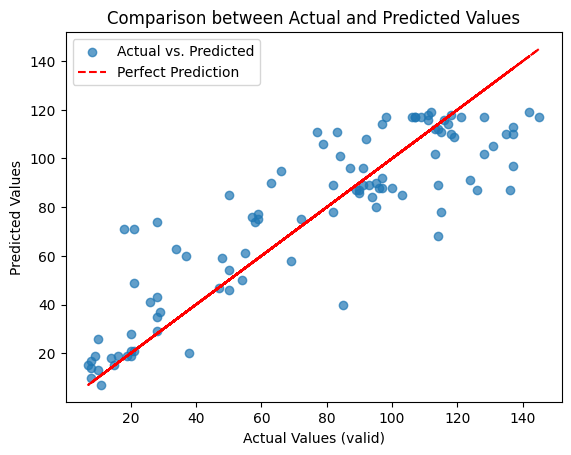

In [119]:
plt.scatter(valid, test_diff_pred['RUL_pred'], label="Actual vs. Predicted", alpha=0.7)
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

# Now lets move onto LSTM models

One of the goals will be the penalize predictions that are over the true RUL values more than those that are under.

In [120]:
train_diff = train_diff.fillna(method='backfill')
if 'RUL_pred' in test_diff.columns:
    test_diff = test_diff.drop(columns=['RUL_pred'])
test_diff = test_diff.fillna(method='backfill')

np.random.seed(42)
random_indices = np.random.choice(list(range(1,101)), size=10, replace=False)

train_split = train_diff[~train_diff['unit_number'].isin(random_indices)]
test_split = train_diff[train_diff['unit_number'].isin(random_indices)]

valid_df = test_diff.copy()

sorted_df = valid_df.sort_values(by=['unit_number', 'time_cycles'], ascending=[True, False])
valid_df['RUL'] = sorted_df['time_cycles'].values

valid_copy = valid.copy()
valid_copy.index = valid_copy.index+1
valid_copy['unit_number'] = valid.index+1

rul_holder = 0

for unit in valid_df['unit_number'].unique():
    rul_holder = valid_copy[valid_copy['unit_number']==unit]['RUL'].values[0] - 1
    valid_df.loc[valid_df['unit_number']==unit, 'RUL'] += rul_holder

In [121]:
def gen_train(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

X_columns = [column for column in train_split.columns if column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

train_split[X_columns] = scaler.transform(train_split[X_columns])
test_split[X_columns] = scaler.transform(test_split[X_columns])
valid_df[X_columns] = scaler.transform(valid_df[X_columns])


In [122]:
dftest.groupby('unit_number')['time_cycles'].max().min()

31

In [123]:
sequence_length = 30

xl_train = np.concatenate(list(list(gen_train(train_split[train_split['unit_number']==unit], sequence_length, X_columns)) for unit in train_split['unit_number'].unique()))
print("X_train: ", xl_train.shape)
yl_train = np.concatenate(list(list(gen_target(train_split[train_split['unit_number']==unit], sequence_length, "RUL")) for unit in train_split['unit_number'].unique()))
print("y_train: ", yl_train.shape)

X_train:  (14241, 30, 128)
y_train:  (14241,)


In [124]:
xl_test = np.concatenate(list(list(gen_train(test_split[test_split['unit_number']==unit], sequence_length, X_columns)) for unit in test_split['unit_number'].unique()))
print("X_test: ", xl_test.shape)
yl_test = np.concatenate(list(list(gen_target(test_split[test_split['unit_number']==unit], sequence_length, "RUL")) for unit in test_split['unit_number'].unique()))
print("y_test: ", yl_test.shape)

X_test:  (3490, 30, 128)
y_test:  (3490,)


In [125]:
valid_x = np.concatenate(list(list(gen_train(valid_df[valid_df['unit_number']==unit], sequence_length, X_columns)) for unit in valid_df['unit_number'].unique()))
print("valid_x: ", valid_x.shape)
valid_y = np.concatenate(list(list(gen_target(valid_df[valid_df['unit_number']==unit], sequence_length, "RUL")) for unit in valid_df['unit_number'].unique()))
print("valid_y: ", valid_y.shape)

valid_x:  (10196, 30, 128)
valid_y:  (10196,)


In [126]:
def custom_asymmetric_loss(y_true, y_pred, alpha=0.8, beta=2, gamma=3):
    y_true = tf.cast(y_true, tf.float32)
    
    diff = y_pred - y_true
    
    pos_diff = tf.maximum(diff, 0) 
    neg_diff = -tf.minimum(diff, 0) 
    
    loss = alpha * neg_diff + gamma * pos_diff  # Increase weight for overestimations
    
    squared_loss = beta * K.square(neg_diff) + gamma * K.square(pos_diff)
    
    combined_loss = loss + squared_loss
    
    return K.mean(combined_loss, axis=-1)

In [127]:
nb_features = xl_train.shape[2]
nb_out = 1

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss=custom_asymmetric_loss, optimizer='adam', metrics=['mse'])
history = model.fit(xl_train, yl_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')]) 

Epoch 1/100
356/356 [==============================] - 14s 35ms/step - loss: 17816.6699 - mse: 8876.5859 - val_loss: 21560.8359 - val_mse: 10747.4316
Epoch 2/100
356/356 [==============================] - 12s 35ms/step - loss: 12296.8496 - mse: 6122.6763 - val_loss: 16169.2422 - val_mse: 8058.6733
Epoch 3/100
356/356 [==============================] - 11s 30ms/step - loss: 8759.9512 - mse: 4353.9995 - val_loss: 12668.6807 - val_mse: 6256.3877
Epoch 4/100
356/356 [==============================] - 10s 29ms/step - loss: 6395.3184 - mse: 3169.0535 - val_loss: 9906.4004 - val_mse: 4930.8813
Epoch 5/100
356/356 [==============================] - 10s 28ms/step - loss: 4791.2842 - mse: 2363.6921 - val_loss: 8610.6035 - val_mse: 4285.1255
Epoch 6/100
356/356 [==============================] - 10s 29ms/step - loss: 3735.1443 - mse: 1829.3751 - val_loss: 6597.0859 - val_mse: 3247.3455
Epoch 7/100
356/356 [==============================] - 10s 29ms/step - loss: 2988.4727 - mse: 1451.8073 - val_lo

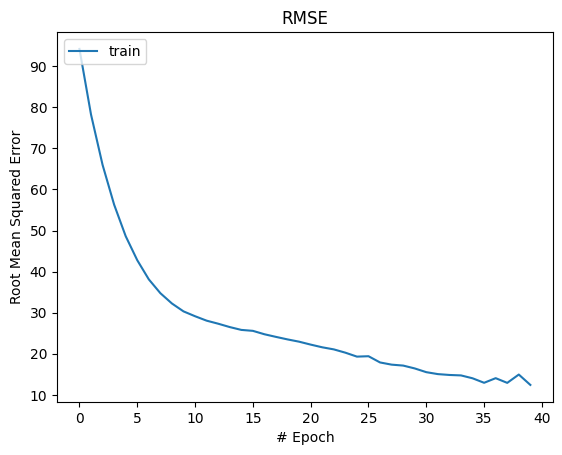

In [128]:
plt.plot(np.sqrt(history.history['mse']))
plt.title('RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

72/72 [==============================] - 3s 37ms/step - loss: 1254.2075 - mse: 583.8488
MSE: 583.8488159179688
RMSE: 24.162963723806083


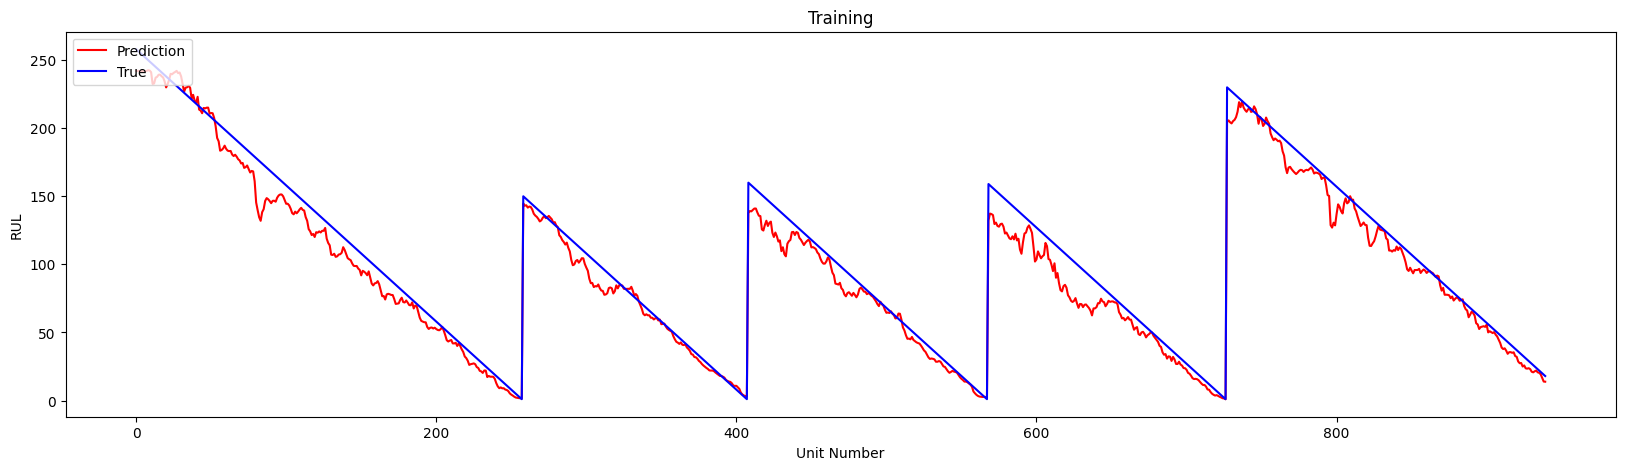

In [129]:
y_pred_train = model.predict(xl_train, verbose=0)
scores_train = model.evaluate(xl_train, yl_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores_train[1]))
print('RMSE: {}'.format(np.sqrt(scores_train[1])))

plt.figure(figsize=(20,5))
plt.plot(y_pred_train[0:940], color='red', label='Prediction')
plt.plot(yl_train[0:940], color='blue', label='True')
plt.title('Training')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

88/88 [==============================] - 1s 11ms/step - loss: 2563.5623 - mse: 1118.6854
MSE: 1118.6854248046875
RMSE: 33.44675507137707


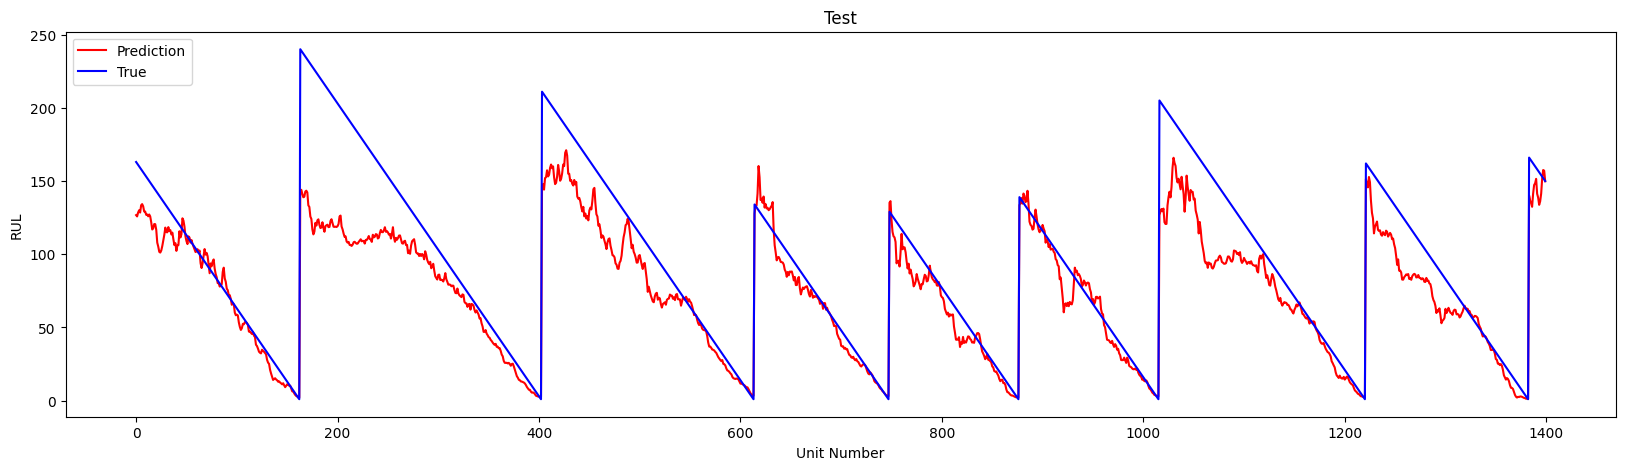

In [130]:
y_pred_test = model.predict(xl_test, verbose=0)
scores_test = model.evaluate(xl_test, yl_test, verbose=1, batch_size=40)
print('MSE: {}'.format(scores_test[1]))
print('RMSE: {}'.format(np.sqrt(scores_test[1])))

plt.figure(figsize=(20,5))
plt.plot(y_pred_test[0:1400], color='red', label='Prediction')
plt.plot(yl_test[0:1400], color='blue', label='True')
plt.title('Test')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

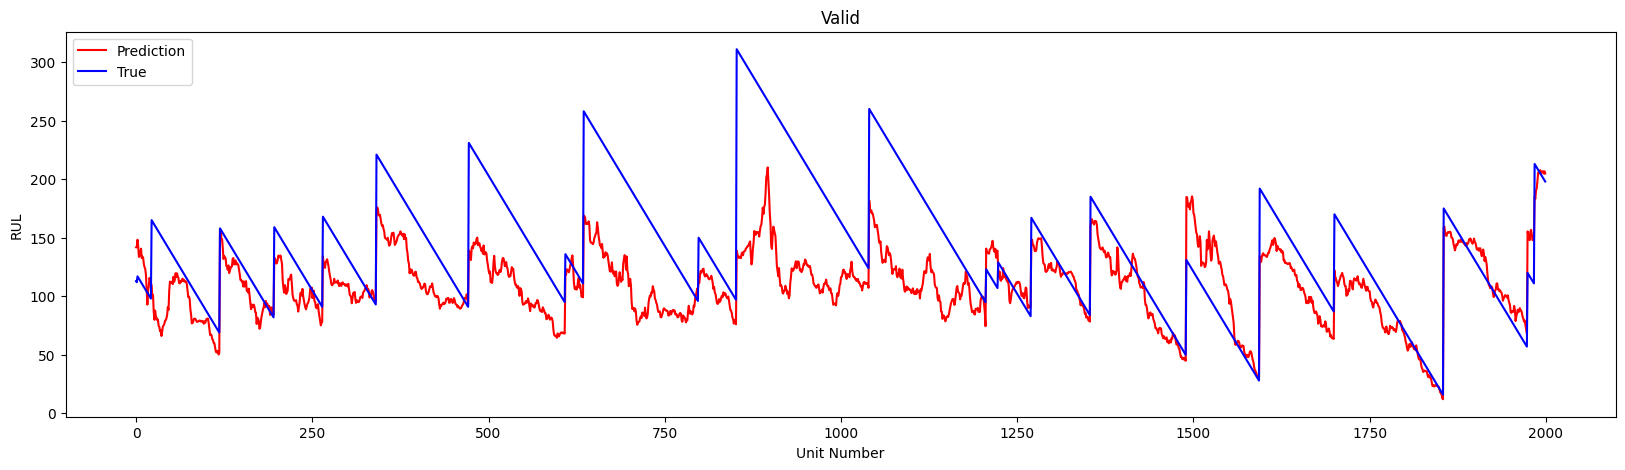

In [131]:
y_pred_valid = model.predict(valid_x, verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_valid[0:2000], color='red', label='Prediction')
plt.plot(valid_y[0:2000], color='blue', label='True')
plt.title('Valid')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

Valid:  set RMSE: 30.91, R2: 0.4468


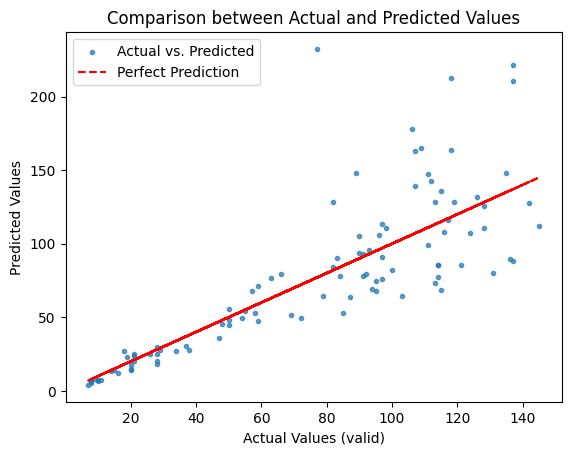

In [132]:
def get_last_predictions_per_unit(valid_x, y_pred, sequence_length):
    last_predictions = []
    index = 0  # Keep track of the current position in valid_x

    for unit_number in valid_df['unit_number'].unique():  # Iterate through unique unit numbers
        unit_data = valid_df[valid_df['unit_number'] == unit_number]
        unit_sequences = unit_data.shape[0] - sequence_length + 1  # Number of sequences for the unit

        last_prediction = y_pred[index + unit_sequences - 1]  # Select the last prediction for the unit
        last_predictions.append(last_prediction[0])  # Extract single value from array

        index += unit_sequences  # Move to the next unit's data in valid_x

    return np.array(last_predictions)

last_predictions_per_unit = get_last_predictions_per_unit(valid_x, y_pred_valid, sequence_length)
evaluate(valid, last_predictions_per_unit, label='Valid: ')

plt.scatter(valid, last_predictions_per_unit, label="Actual vs. Predicted", alpha=0.7, marker='.')
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

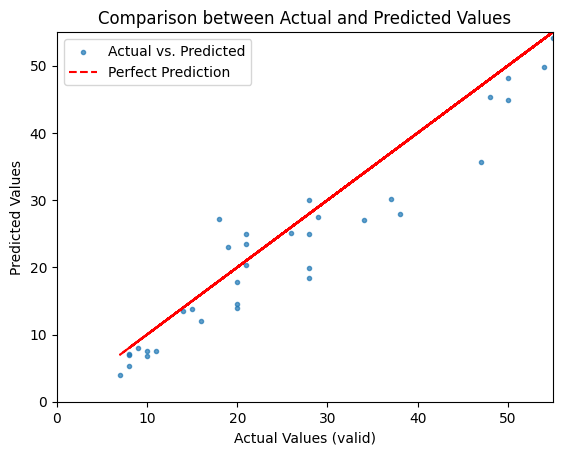

In [133]:
plt.scatter(valid, last_predictions_per_unit, label="Actual vs. Predicted", alpha=0.7, marker='.')
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

### Now lets do LSTM on the capped dataset

In [134]:
# now lets try on the filtered dataset 

to_include = [ 'unit_number', 'RUL', 'time_cycles']
for x in to_include:
    if x not in corr_list:
        corr_list.append(x)
train_corr = train_diff[corr_list]

train_corr.loc[train_corr['RUL'] > 120, 'RUL'] = 120

np.random.seed(42)
random_indices = np.random.choice(list(range(1,101)), size=10, replace=False)

train_split = train_corr[~train_corr['unit_number'].isin(random_indices)]
test_split = train_corr[train_corr['unit_number'].isin(random_indices)]

valid_df = test_diff.copy()

sorted_df = valid_df.sort_values(by=['unit_number', 'time_cycles'], ascending=[True, False])
valid_df['RUL'] = sorted_df['time_cycles'].values

valid_copy = valid.copy()
valid_copy.index = valid_copy.index+1
valid_copy['unit_number'] = valid.index+1

rul_holder = 0

for unit in valid_df['unit_number'].unique():
    rul_holder = valid_copy[valid_copy['unit_number']==unit]['RUL'].values[0] - 1
    valid_df.loc[valid_df['unit_number']==unit, 'RUL'] += rul_holder

valid_df = valid_df[corr_list]
valid_df.loc[valid_df['RUL'] > 120, 'RUL'] = 120

X_columns = [column for column in train_split.columns if column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

train_split[X_columns] = scaler.transform(train_split[X_columns])
test_split[X_columns] = scaler.transform(test_split[X_columns])
valid_df[X_columns] = scaler.transform(valid_df[X_columns])

In [135]:
sequence_length = 30

xl_train = np.concatenate(list(list(gen_train(train_split[train_split['unit_number']==unit], sequence_length, X_columns)) for unit in train_split['unit_number'].unique()))
print("X_train: ", xl_train.shape)
yl_train = np.concatenate(list(list(gen_target(train_split[train_split['unit_number']==unit], sequence_length, "RUL")) for unit in train_split['unit_number'].unique()))
print("y_train: ", yl_train.shape)

X_train:  (14241, 30, 126)
y_train:  (14241,)


In [136]:
xl_test = np.concatenate(list(list(gen_train(test_split[test_split['unit_number']==unit], sequence_length, X_columns)) for unit in test_split['unit_number'].unique()))
print("X_train: ", xl_test.shape)
yl_test = np.concatenate(list(list(gen_target(test_split[test_split['unit_number']==unit], sequence_length, "RUL")) for unit in test_split['unit_number'].unique()))
print("y_train: ", yl_test.shape)

X_train:  (3490, 30, 126)
y_train:  (3490,)


In [137]:
valid_x = np.concatenate(list(list(gen_train(valid_df[valid_df['unit_number']==unit], sequence_length, X_columns)) for unit in valid_df['unit_number'].unique()))
print("X_train: ", valid_x.shape)
valid_y = np.concatenate(list(list(gen_target(valid_df[valid_df['unit_number']==unit], sequence_length, "RUL")) for unit in valid_df['unit_number'].unique()))
print("y_train: ", valid_y.shape)

X_train:  (10196, 30, 126)
y_train:  (10196,)


In [138]:
nb_features = xl_train.shape[2]
nb_out = 1

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss=custom_asymmetric_loss, optimizer='adam', metrics=['mse'])
history = model.fit(xl_train, yl_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]) 

Epoch 1/100
356/356 [==============================] - 14s 37ms/step - loss: 10229.2822 - mse: 5088.4360 - val_loss: 8467.8867 - val_mse: 4211.6138
Epoch 2/100
356/356 [==============================] - 12s 34ms/step - loss: 6060.3931 - mse: 3009.0767 - val_loss: 5091.8047 - val_mse: 2528.6199
Epoch 3/100
356/356 [==============================] - 11s 31ms/step - loss: 3531.9753 - mse: 1747.9932 - val_loss: 2964.2712 - val_mse: 1458.7255
Epoch 4/100
356/356 [==============================] - 10s 29ms/step - loss: 2068.5745 - mse: 1015.2107 - val_loss: 1874.5225 - val_mse: 885.7029
Epoch 5/100
356/356 [==============================] - 10s 28ms/step - loss: 1231.3781 - mse: 595.5395 - val_loss: 1064.7965 - val_mse: 513.8738
Epoch 6/100
356/356 [==============================] - 10s 27ms/step - loss: 768.9149 - mse: 361.3678 - val_loss: 698.8672 - val_mse: 310.2033
Epoch 7/100
356/356 [==============================] - 10s 28ms/step - loss: 527.5467 - mse: 238.8572 - val_loss: 521.1489 -

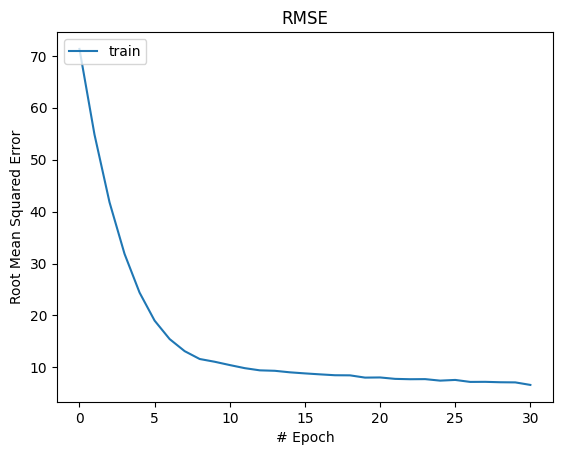

In [139]:
plt.plot(np.sqrt(history.history['mse']))
plt.title('RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

72/72 [==============================] - 3s 38ms/step - loss: 121.6092 - mse: 50.2590
MSE: 50.258995056152344
RMSE: 7.089357873330443


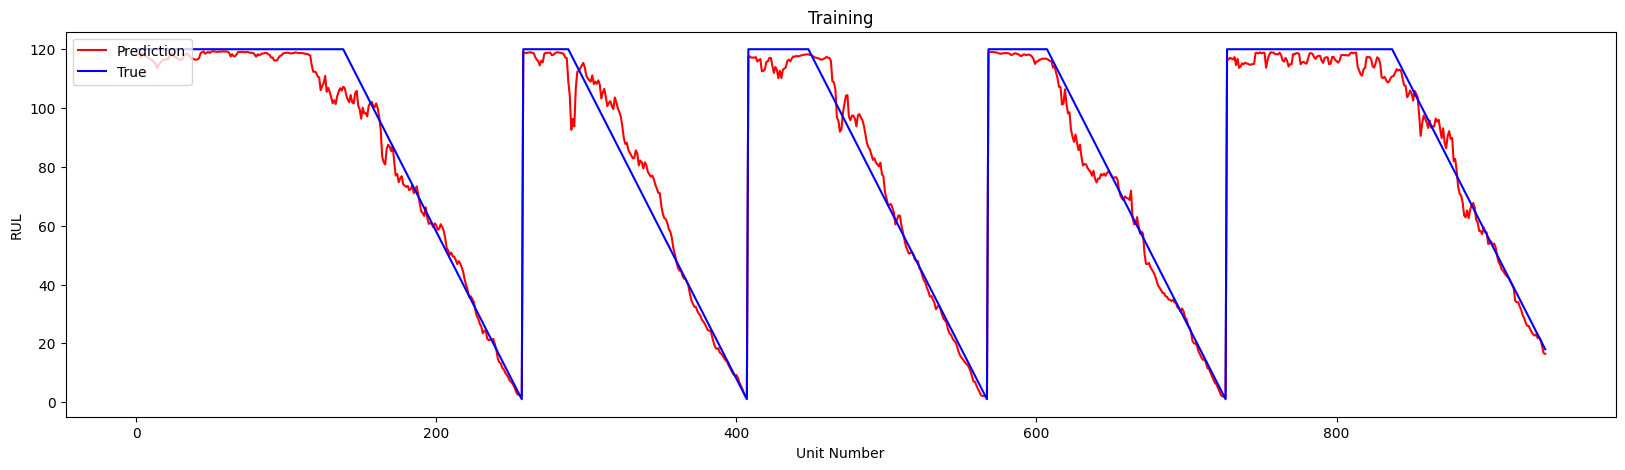

In [140]:
y_pred_train = model.predict(xl_train, verbose=0)
scores_train = model.evaluate(xl_train, yl_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores_train[1]))
print('RMSE: {}'.format(np.sqrt(scores_train[1])))

plt.figure(figsize=(20,5))
plt.plot(y_pred_train[0:940], color='red', label='Prediction')
plt.plot(yl_train[0:940], color='blue', label='True')
plt.title('Training')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

88/88 [==============================] - 1s 11ms/step - loss: 273.0869 - mse: 108.5754
MSE: 108.57535552978516
RMSE: 10.419949881347087


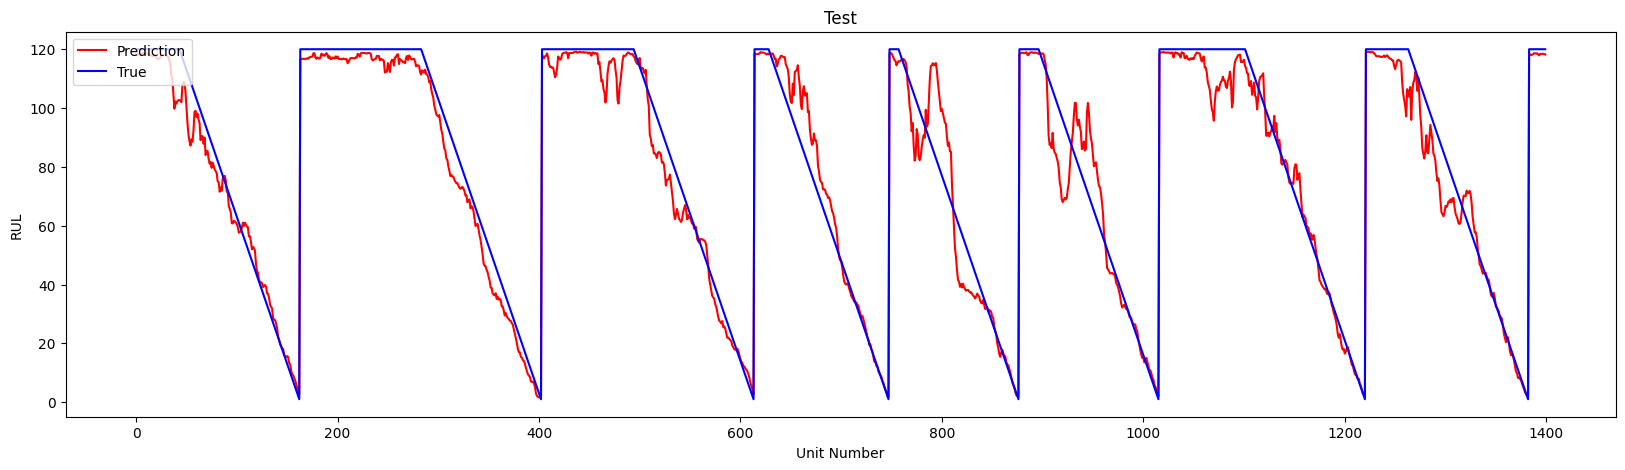

In [141]:
y_pred_test = model.predict(xl_test, verbose=0)
scores_test = model.evaluate(xl_test, yl_test, verbose=1, batch_size=40)
print('MSE: {}'.format(scores_test[1]))
print('RMSE: {}'.format(np.sqrt(scores_test[1])))

plt.figure(figsize=(20,5))
plt.plot(y_pred_test[0:1400], color='red', label='Prediction')
plt.plot(yl_test[0:1400], color='blue', label='True')
plt.title('Test')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

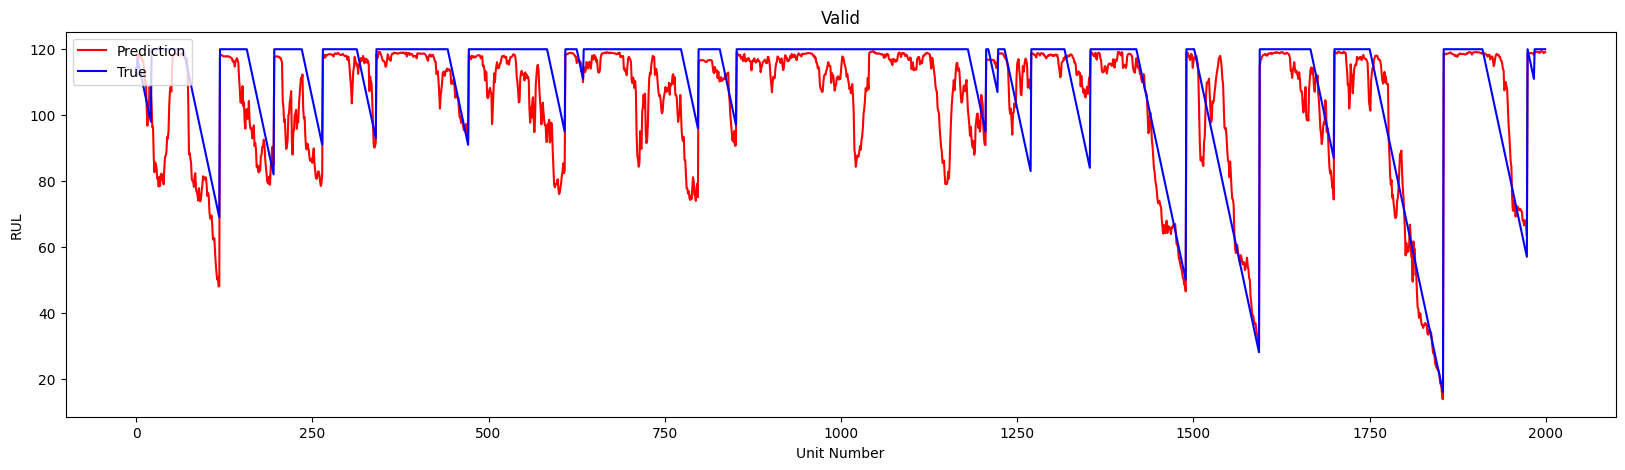

In [142]:
y_pred_valid = model.predict(valid_x, verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_valid[0:2000], color='red', label='Prediction')
plt.plot(valid_y[0:2000], color='blue', label='True')
plt.title('Valid')
plt.ylabel('RUL')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

Valid:  set RMSE: 15.84, R2: 0.8548


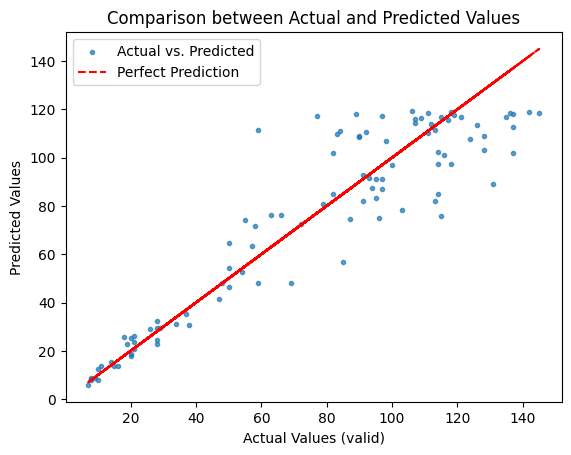

In [143]:
last_predictions_per_unit = get_last_predictions_per_unit(valid_x, y_pred_valid, sequence_length)
evaluate(valid, last_predictions_per_unit, label='Valid: ')

plt.scatter(valid, last_predictions_per_unit, label="Actual vs. Predicted", alpha=0.7, marker='.')
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

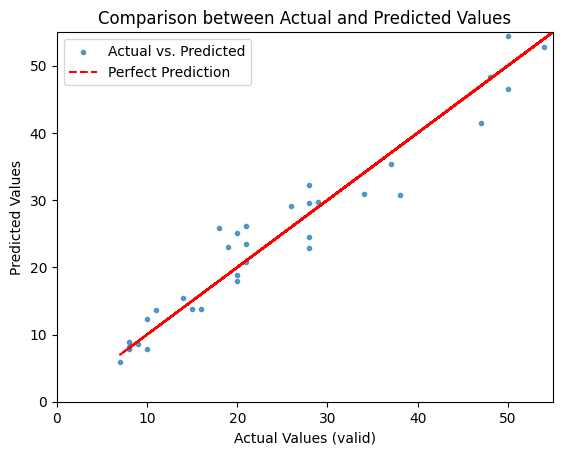

In [144]:
plt.scatter(valid, last_predictions_per_unit, label="Actual vs. Predicted", alpha=0.7, marker='.')
plt.plot(valid, valid, color='red', label="Perfect Prediction", linestyle='--')
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

In the plot that graphs the True values against the Predictions for the whole lifecycle, not the scatter plot above, we can see clear signs of underguessing. While it may seem like a large error, it is much safer to predict lower values of the RUL and turn the engine off early, than to over-predict the RUL and have the engine fail during use.

# Now lets move onto classification on LSTM and Random Forest

In [145]:
class_train = train_diff[corr_list].copy()
filtered_corr_list = [col for col in corr_list if col != 'RUL']
class_test = test_diff[filtered_corr_list].copy()

| Health Classification  | Ratio of RUL      | Hard Cutoffs of RUL         |
|------------------------|-------------------|-----------------------------|
| Healthy                | 0 ≤ r ≤ 0.39      | 120 ≤ RUL                   |
| Some Wear              | 0.40 ≤ r ≤ 0.69   | 70 ≤ RUL ≤ 119              |
| Significant Damage     | 0.70 ≤ r ≤ 0.89   | 30 ≤ RUL ≤ 69               |
| Failure Imminent       | 0.90 ≤ r ≤ 1.0    | RUL < 30                    |


I'll prepare two types of datasets based on the two types of classifications above. First we'll classify the RUL based with hard cutoffs, such as any RUL at 120 or above is classified as Healthy or 0. RUL below 30 will classified as Failure Imminent or 3. The second dataset will be based off of ratio of the current RUL to the Max RUL for that engine. If a unit has a Max RUL of 200, an RUL of 180 or above will be classified as Failure Imminent or 3.

I am lowering the penalties for the 3rd and 4th class, if we're able to stop the engines before failure by correctly predicting the 4th Failure class every time, we'll be able to save more money than if the engine went to failure.

In [146]:
hard_cut_train = class_train.copy()
hard_cut_test = class_test.copy()

ratio_cut_train = class_train.copy()
ratio_cut_test = class_test.copy()

valid_hard_cut = valid.copy()

sorted_df = hard_cut_test.sort_values(by=['unit_number', 'time_cycles'], ascending=[True, False])
hard_cut_test['RUL'] = sorted_df['time_cycles'].values

valid_hard_cut.index = valid_hard_cut.index+1
valid_hard_cut['unit_number'] = valid.index+1

rul_holder = 0

for unit in hard_cut_test['unit_number'].unique():
    rul_holder = valid_hard_cut[valid_hard_cut['unit_number']==unit]['RUL'].values[0] - 1
    hard_cut_test.loc[hard_cut_test['unit_number']==unit, 'RUL'] += rul_holder

bins = [0, 29, 69, 119, float('inf')]
labels = [3, 2, 1, 0]

hard_cut_train['health'] = pd.cut(hard_cut_train['RUL'], bins=bins, labels=labels, right=True)
hard_cut_test['health'] = pd.cut(hard_cut_test['RUL'], bins=bins, labels=labels, right=True)
valid_hard_cut['health'] = pd.cut(valid_hard_cut['RUL'], bins=bins, labels=labels, right=True)

ratio_cut_train['max_rul'] = ratio_cut_train.groupby('unit_number')['RUL'].transform(max)
ratio_cut_train['health_ratio'] = round(ratio_cut_train['time_cycles']/ratio_cut_train['max_rul'], 4)
ratio_cut_train.drop(columns=['max_rul'], inplace=True)

sorted_df = ratio_cut_test.sort_values(by=['unit_number', 'time_cycles'], ascending=[True, False])
ratio_cut_test['RUL'] = sorted_df['time_cycles'].values

valid_ratio_cut = valid.copy()
valid_ratio_cut.index = valid_ratio_cut.index+1
valid_ratio_cut['unit_number'] = valid.index+1

rul_holder = 0

for unit in ratio_cut_test['unit_number'].unique():
    rul_holder = valid_ratio_cut[valid_ratio_cut['unit_number']==unit]['RUL'].values[0] - 1
    ratio_cut_test.loc[ratio_cut_test['unit_number']==unit, 'RUL'] += rul_holder

ratio_cut_test['max_rul'] = ratio_cut_test.groupby('unit_number')['RUL'].transform(max)
ratio_cut_test['health_ratio'] = round(ratio_cut_test['time_cycles']/ratio_cut_test['max_rul'], 4)
ratio_cut_test.drop(columns=['max_rul'], inplace=True)

bins2 = [0, 0.39, .69, 0.89, 1]
labels2 = [0, 1, 2, 3]

ratio_cut_train['health'] = pd.cut(ratio_cut_train['health_ratio'], bins=bins2, labels=labels2, right=True)
ratio_cut_test['health'] = pd.cut(ratio_cut_test['health_ratio'], bins=bins2, labels=labels2, right=True)
ratio_cut_test.drop(columns=['health_ratio'], inplace=True)
valid_ratio_cut = ratio_cut_test.groupby('unit_number')['health'].last().reset_index()

ratio_cut_train.drop(columns=['health_ratio'], inplace=True)

In [147]:
hard_cut_train['health']

0        0
1        0
2        0
3        0
4        0
        ..
20626    3
20627    3
20628    3
20629    3
20630    3
Name: health, Length: 20631, dtype: category
Categories (4, int64): [3 < 2 < 1 < 0]

In [148]:
ratio_cut_train['health']

0        0
1        0
2        0
3        0
4        0
        ..
20626    3
20627    3
20628    3
20629    3
20630    3
Name: health, Length: 20631, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

### Below we classify on the Hardcut dataset

In [149]:
random_indices = np.random.choice(list(range(1,101)), size=10, replace=False)

train_split = hard_cut_train[~hard_cut_train['unit_number'].isin(random_indices)]
test_split = hard_cut_train[hard_cut_train['unit_number'].isin(random_indices)]

valid_df = hard_cut_test.copy()

#####

X_columns = [column for column in train_split.columns if column != "health" and column != "health_ratio" and column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

train_split[X_columns] = scaler.transform(train_split[X_columns])
test_split[X_columns] = scaler.transform(test_split[X_columns])
valid_df[X_columns] = scaler.transform(valid_df[X_columns])

#####

sequence_length = 30

xl_train = np.concatenate(list(list(gen_train(train_split[train_split['unit_number']==unit], sequence_length, X_columns)) for unit in train_split['unit_number'].unique()))
print("X_train: ", xl_train.shape)
yl_train = np.concatenate(list(list(gen_target(train_split[train_split['unit_number']==unit], sequence_length, "health")) for unit in train_split['unit_number'].unique()))
hard_cut_train_health_cat = to_categorical(np.array(yl_train), num_classes=4)
print("y_train: ", hard_cut_train_health_cat.shape)

xl_test = np.concatenate(list(list(gen_train(test_split[test_split['unit_number']==unit], sequence_length, X_columns)) for unit in test_split['unit_number'].unique()))
print("X_test: ", xl_test.shape)
yl_test = np.concatenate(list(list(gen_target(test_split[test_split['unit_number']==unit], sequence_length, "health")) for unit in test_split['unit_number'].unique()))
hard_cut_test_health_cat = to_categorical(np.array(yl_test), num_classes=4)
print("y_test: ", hard_cut_test_health_cat.shape)

valid_x = np.concatenate(list(list(gen_train(valid_df[valid_df['unit_number']==unit], sequence_length, X_columns)) for unit in valid_df['unit_number'].unique()))
print("valid_x: ", valid_x.shape)
valid_y = np.concatenate(list(list(gen_target(valid_df[valid_df['unit_number']==unit], sequence_length, "health")) for unit in valid_df['unit_number'].unique()))
hard_cut_valid_health_cat = to_categorical(np.array(valid_y), num_classes=4)
print("valid_y: ", hard_cut_valid_health_cat.shape)

####

def custom_asymmetric_categorical_crossentropy(y_true, y_pred):
    # Set penalties: less penalty for the 3rd and 4th class to make them more likely to be predicted
    scale = tf.constant([1.0, 1.0, .95, 0.9])
    
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    weighted_ce = ce * tf.reduce_sum(y_true * scale, axis=-1)
    
    return tf.reduce_mean(weighted_ce)

####

nb_features = xl_train.shape[2]

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=4, activation='softmax'))
model.compile(loss=custom_asymmetric_categorical_crossentropy, optimizer="rmsprop", metrics=['accuracy'])
history = model.fit(xl_train, hard_cut_train_health_cat, epochs=30, batch_size=32, validation_split=0.01, verbose=1,
                callbacks=[EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)])

X_train:  (14109, 30, 126)
y_train:  (14109, 4)
X_test:  (3622, 30, 126)
y_test:  (3622, 4)
valid_x:  (10196, 30, 126)
valid_y:  (10196, 4)
Epoch 1/30
437/437 [==============================] - 15s 31ms/step - loss: 0.6433 - accuracy: 0.7016 - val_loss: 0.7279 - val_accuracy: 0.5704
Epoch 2/30
437/437 [==============================] - 12s 28ms/step - loss: 0.5038 - accuracy: 0.7729 - val_loss: 0.9347 - val_accuracy: 0.6268
Epoch 3/30
437/437 [==============================] - 12s 28ms/step - loss: 0.4447 - accuracy: 0.8001 - val_loss: 1.6439 - val_accuracy: 0.5070
Epoch 4/30
437/437 [==============================] - 12s 28ms/step - loss: 0.4050 - accuracy: 0.8224 - val_loss: 0.9128 - val_accuracy: 0.5986
Epoch 5/30
437/437 [==============================] - 12s 28ms/step - loss: 0.3710 - accuracy: 0.8421 - val_loss: 0.8276 - val_accuracy: 0.6901
Epoch 6/30
437/437 [==============================] - 12s 28ms/step - loss: 0.3354 - accuracy: 0.8571 - val_loss: 1.1376 - val_accuracy: 0.3

441/441 [==============================] - 4s 8ms/step


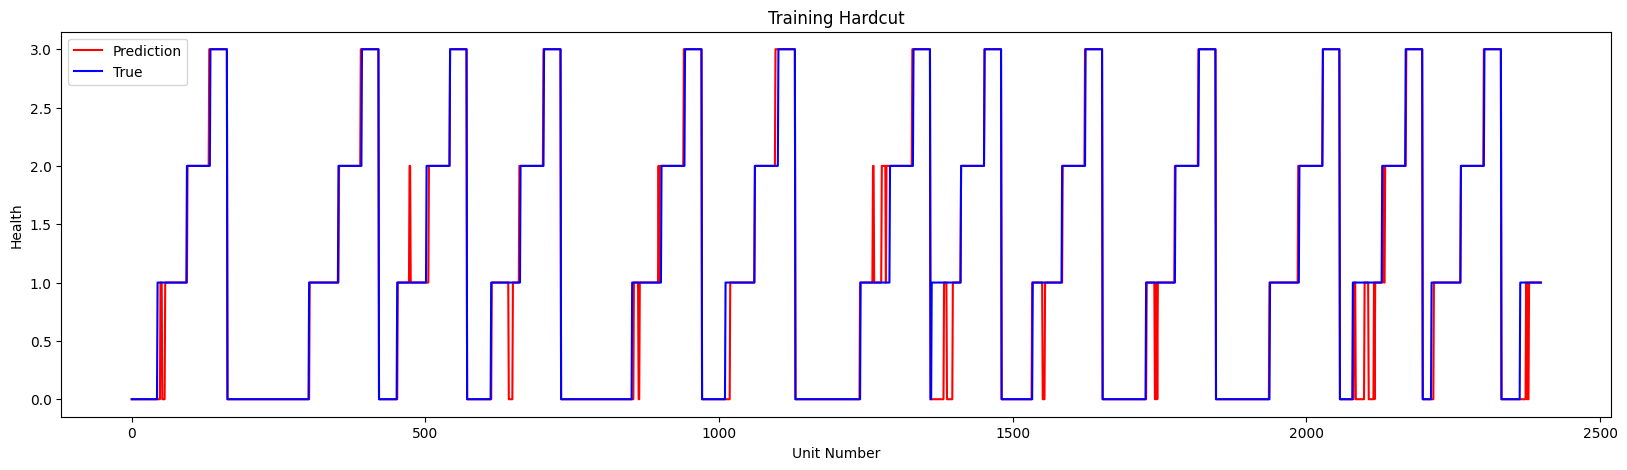

114/114 [==============================] - 1s 8ms/step


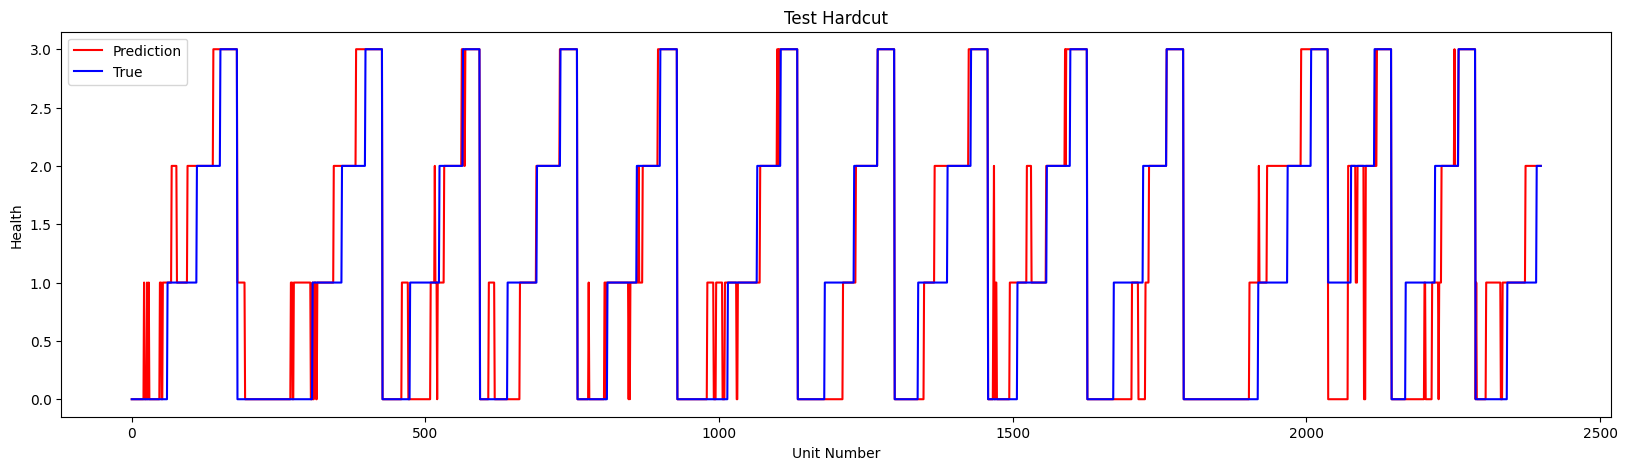

319/319 [==============================] - 3s 8ms/step


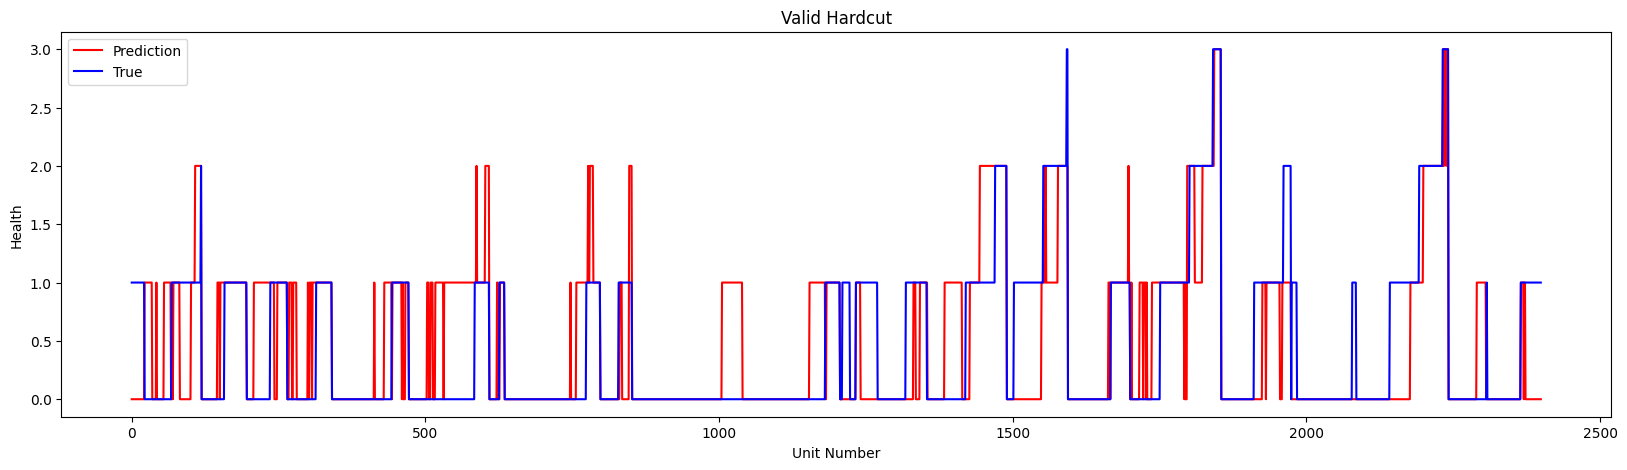

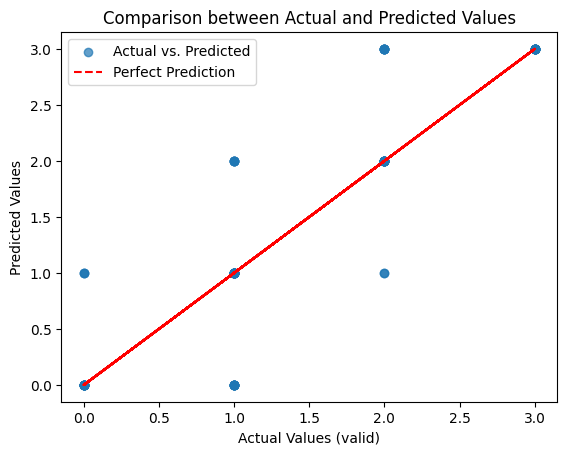

In [150]:
y_pred_train = model.predict(xl_train, verbose=1)
y_train_integers = np.argmax(hard_cut_train_health_cat, axis=1)
y_pred_train_integers = np.argmax(y_pred_train, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_train_integers[0:2400], color='red', label='Prediction')
plt.plot(y_train_integers[0:2400], color='blue', label='True')
plt.title('Training Hardcut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

####
y_pred_test = model.predict(xl_test, verbose=1)
y_test_integers = np.argmax(hard_cut_test_health_cat, axis=1)
y_pred_test_integers = np.argmax(y_pred_test, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test_integers[0:2400], color='red', label='Prediction')
plt.plot(y_test_integers[0:2400], color='blue', label='True')
plt.title('Test Hardcut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

####

y_pred_valid = model.predict(valid_x, verbose=1)
y_valid_integers = np.argmax(hard_cut_valid_health_cat, axis=1)
y_pred_valid_integers = np.argmax(y_pred_valid, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_valid_integers[0:2400], color='red', label='Prediction')
plt.plot(y_valid_integers[0:2400], color='blue', label='True')
plt.title('Valid Hardcut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

###

def get_last_predictions_per_unit2(valid_x, y_pred, sequence_length):
    last_predictions = []
    index = 0 

    for unit_number in valid_df['unit_number'].unique():
        unit_data = valid_df[valid_df['unit_number'] == unit_number]
        unit_sequences = unit_data.shape[0] - sequence_length + 1

        last_prediction = y_pred[index + unit_sequences - 1]
        last_predictions.append(last_prediction)

        index += unit_sequences

    return np.array(last_predictions)

last_predictions_per_unit = get_last_predictions_per_unit2(valid_x, y_pred_valid, sequence_length)
y_valid_integers_last = np.argmax(last_predictions_per_unit, axis=1)


plt.scatter(valid_ratio_cut['health'], y_valid_integers_last, label="Actual vs. Predicted", alpha=0.7)
plt.plot(valid_ratio_cut['health'], valid_ratio_cut['health'], color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

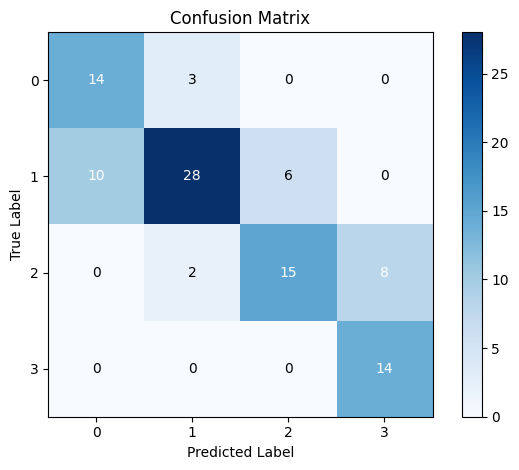

In [151]:
cm = confusion_matrix(valid_ratio_cut['health'], y_valid_integers_last)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels and ticks for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.mean() else 'black')


plt.xticks(range(cm.shape[1]), ['0', '1', '2', '3'])  # Adjust according to your class labels
plt.yticks(range(cm.shape[0]), ['0', '1', '2', '3'])  # Adjust according to your class labels
plt.tight_layout()
plt.show()


## Confusion Matrix for Business Applications

A different perspective of the Confusion Matrix as a Cost-Benefit Matrix, specifically by looking at class 3 predictions only. 
We'll assume the following:
 <br><br><br>

True Positive (TP): Engines that need maintenance and are correctly selected, Cost: +$300,000

True Negative (TN): Engines that are okay and not selected, Cost: $0

False Positive (FP): Engines that are okay but unnecessarily selected, Cost: -$100,000

False Negative (FN): Engines that need maintenance but are not selected, Cost: -$500,000


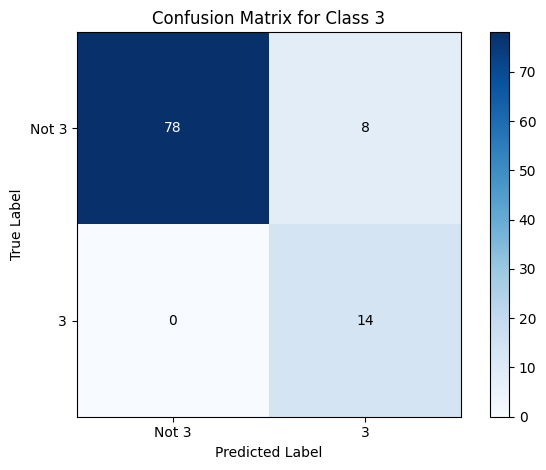

In [152]:
# Convert to binary problem: is the class '3' or not ('3' is positive, others are negative)

y_true_binary = (valid_ratio_cut['health'] == 3).astype(int)
y_pred_binary = (y_valid_integers_last == 3).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for Class 3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', 
                 color='white' if cm[i, j] > threshold else 'black')


plt.xticks(range(2), ['Not 3', '3'])
plt.yticks(range(2), ['Not 3', '3'])
plt.tight_layout()
plt.show()


In [153]:
# Assign your custom weights
TP_weight = 300000
TN_weight = 0
FP_weight = -100000
FN_weight = -500000

# Calculate the weighted values
TP = cm[1, 1] * TP_weight
TN = cm[0, 0] * TN_weight
FP = cm[0, 1] * FP_weight
FN = cm[1, 0] * FN_weight

# Sum all the weighted values to get a single performance score
weighted_score = TP + TN + FP + FN

print(f'Weighted Score: {weighted_score}')

Weighted Score: 3400000


### Below we classify on the Ratiocut dataset

In [154]:
np.random.seed(42)
random_indices = np.random.choice(list(range(1,101)), size=10, replace=False)

train_split = ratio_cut_train[~ratio_cut_train['unit_number'].isin(random_indices)]
test_split = ratio_cut_train[ratio_cut_train['unit_number'].isin(random_indices)]

valid_df = ratio_cut_test.copy()

#####

X_columns = [column for column in train_split.columns if column != "health" and column != "health_ratio" and column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

train_split[X_columns] = scaler.transform(train_split[X_columns])
test_split[X_columns] = scaler.transform(test_split[X_columns])
valid_df[X_columns] = scaler.transform(valid_df[X_columns])

#####

sequence_length = 30

xl_train = np.concatenate(list(list(gen_train(train_split[train_split['unit_number']==unit], sequence_length, X_columns)) for unit in train_split['unit_number'].unique()))
print("X_train: ", xl_train.shape)
yl_train = np.concatenate(list(list(gen_target(train_split[train_split['unit_number']==unit], sequence_length, "health")) for unit in train_split['unit_number'].unique()))
ratio_cut_train_health_cat = to_categorical(np.array(yl_train), num_classes=4)
print("y_train: ", ratio_cut_train_health_cat.shape)

xl_test = np.concatenate(list(list(gen_train(test_split[test_split['unit_number']==unit], sequence_length, X_columns)) for unit in test_split['unit_number'].unique()))
print("X_test: ", xl_test.shape)
yl_test = np.concatenate(list(list(gen_target(test_split[test_split['unit_number']==unit], sequence_length, "health")) for unit in test_split['unit_number'].unique()))
ratio_cut_test_health_cat = to_categorical(np.array(yl_test), num_classes=4)
print("y_test: ", ratio_cut_test_health_cat.shape)

valid_x = np.concatenate(list(list(gen_train(valid_df[valid_df['unit_number']==unit], sequence_length, X_columns)) for unit in valid_df['unit_number'].unique()))
print("valid_x: ", valid_x.shape)
valid_y = np.concatenate(list(list(gen_target(valid_df[valid_df['unit_number']==unit], sequence_length, "health")) for unit in valid_df['unit_number'].unique()))
ratio_cut_valid_health_cat = to_categorical(np.array(valid_y), num_classes=4)
print("valid_y: ", ratio_cut_valid_health_cat.shape)

####
nb_features = xl_train.shape[2]

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=4, activation='softmax'))
model.compile(loss=custom_asymmetric_categorical_crossentropy, optimizer="rmsprop", metrics=['accuracy'])

history = model.fit(xl_train, ratio_cut_train_health_cat, epochs=30, batch_size=32, validation_split=0.01, verbose=1,
                callbacks=[EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)])

X_train:  (14241, 30, 126)
y_train:  (14241, 4)
X_test:  (3490, 30, 126)
y_test:  (3490, 4)
valid_x:  (10196, 30, 126)
valid_y:  (10196, 4)
Epoch 1/30
441/441 [==============================] - 13s 27ms/step - loss: 0.5184 - accuracy: 0.7651 - val_loss: 0.9827 - val_accuracy: 0.3986
Epoch 2/30
441/441 [==============================] - 12s 27ms/step - loss: 0.3773 - accuracy: 0.8323 - val_loss: 1.6178 - val_accuracy: 0.3566
Epoch 3/30
441/441 [==============================] - 12s 27ms/step - loss: 0.3315 - accuracy: 0.8564 - val_loss: 0.4867 - val_accuracy: 0.7552
Epoch 4/30
441/441 [==============================] - 12s 27ms/step - loss: 0.3028 - accuracy: 0.8716 - val_loss: 1.0165 - val_accuracy: 0.6923
Epoch 5/30
441/441 [==============================] - 12s 27ms/step - loss: 0.2861 - accuracy: 0.8786 - val_loss: 1.2849 - val_accuracy: 0.5035
Epoch 6/30
441/441 [==============================] - 11s 26ms/step - loss: 0.2596 - accuracy: 0.8901 - val_loss: 1.0454 - val_accuracy: 0.7

72/72 [==============================] - 3s 40ms/step - loss: 0.1649 - accuracy: 0.9353
MSE: 0.9353275895118713
RMSE: 0.9671233579600232


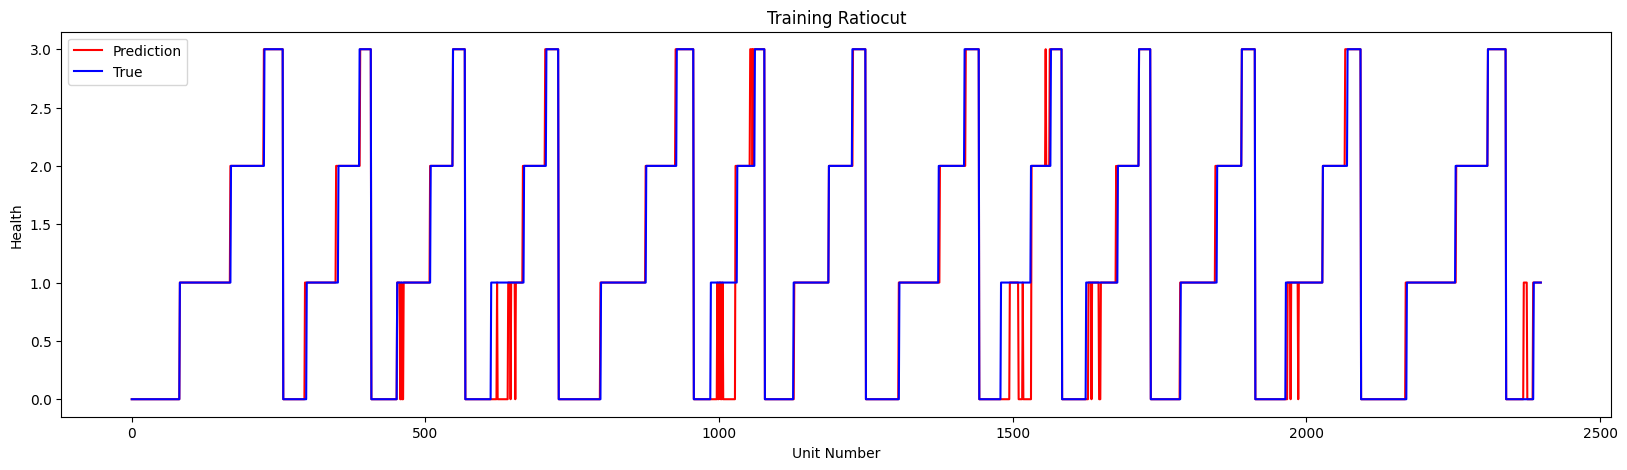

18/18 [==============================] - 1s 38ms/step - loss: 0.5729 - accuracy: 0.8264
MSE: 0.8263610601425171
RMSE: 0.9090440364154627


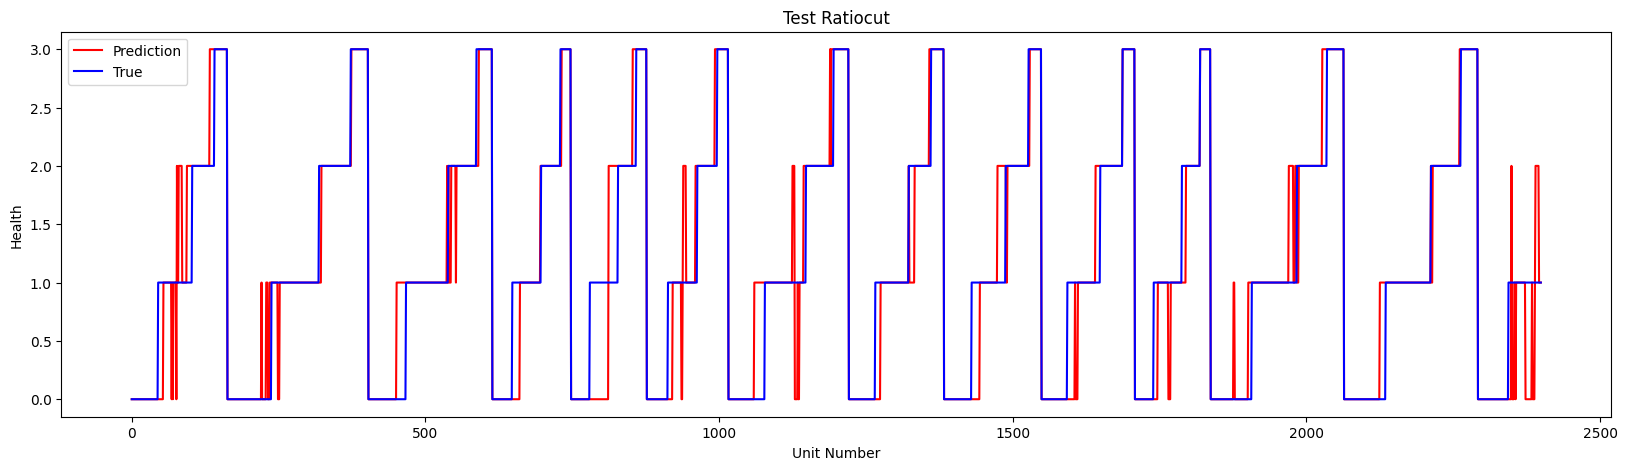

319/319 [==============================] - 3s 8ms/step


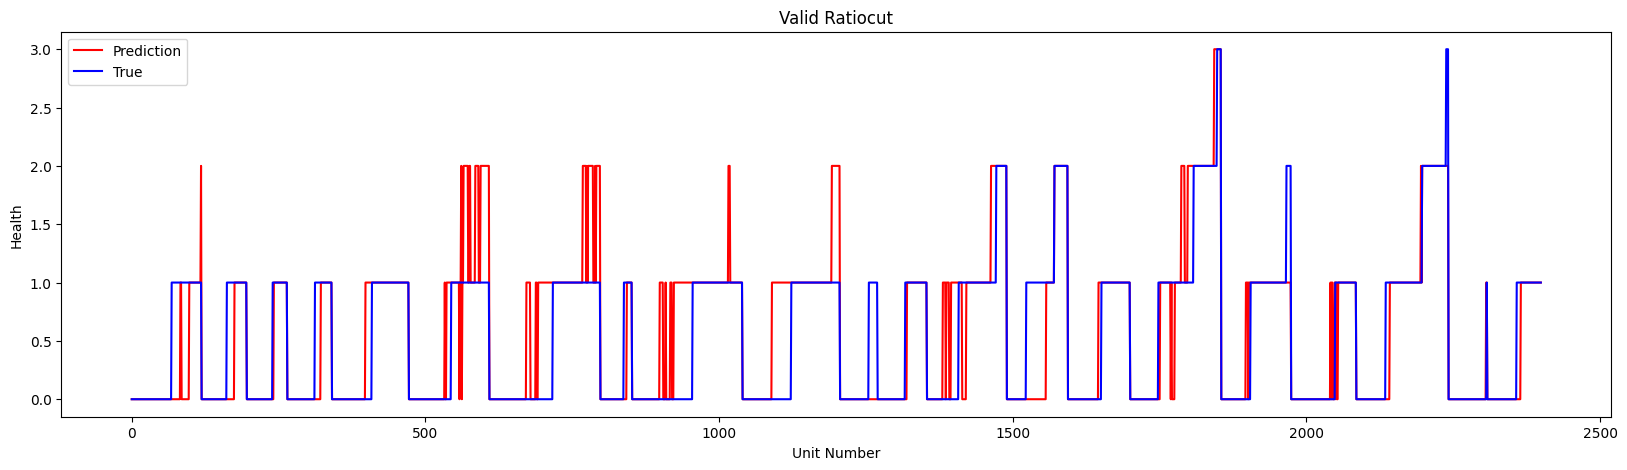

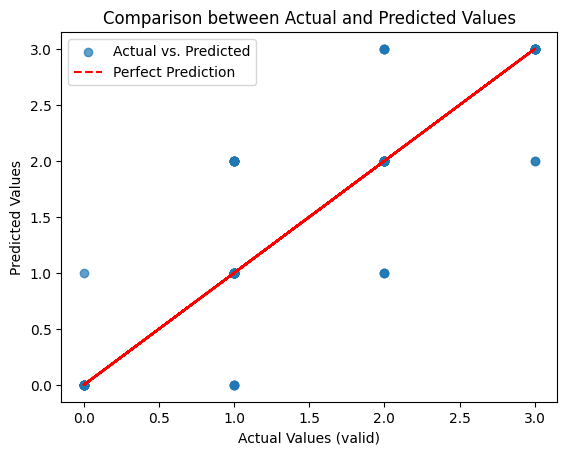

In [155]:
y_pred_train = model.predict(xl_train, verbose=1)
scores = model.evaluate(xl_train, ratio_cut_train_health_cat, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))
print('RMSE: {}'.format(np.sqrt(scores[1])))

y_train_integers = np.argmax(ratio_cut_train_health_cat, axis=1)
y_pred_train_integers = np.argmax(y_pred_train, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_train_integers[0:2400], color='red', label='Prediction')
plt.plot(y_train_integers[0:2400], color='blue', label='True')
plt.title('Training Ratiocut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

####

y_pred_test = model.predict(xl_test, verbose=1)
scores = model.evaluate(xl_test, ratio_cut_test_health_cat, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))
print('RMSE: {}'.format(np.sqrt(scores[1])))

y_test_integers = np.argmax(ratio_cut_test_health_cat, axis=1)
y_pred_test_integers = np.argmax(y_pred_test, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test_integers[0:2400], color='red', label='Prediction')
plt.plot(y_test_integers[0:2400], color='blue', label='True')
plt.title('Test Ratiocut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

####

y_pred_valid = model.predict(valid_x, verbose=1)
y_valid_integers = np.argmax(ratio_cut_valid_health_cat, axis=1)
y_pred_valid_integers = np.argmax(y_pred_valid, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_valid_integers[0:2400], color='red', label='Prediction')
plt.plot(y_valid_integers[0:2400], color='blue', label='True')
plt.title('Valid Ratiocut')
plt.ylabel('Health')
plt.xlabel('Unit Number')
plt.legend(loc='upper left')
plt.show()

###

last_predictions_per_unit = get_last_predictions_per_unit2(valid_x, y_pred_valid, sequence_length)
y_valid_integers_last = np.argmax(last_predictions_per_unit, axis=1)

####

plt.scatter(valid_ratio_cut['health'], y_valid_integers_last, label="Actual vs. Predicted", alpha=0.7)
plt.plot(valid_ratio_cut['health'], valid_ratio_cut['health'], color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

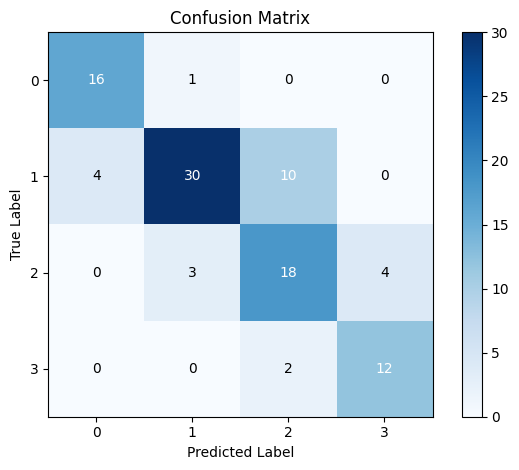

In [156]:
cm = confusion_matrix(valid_ratio_cut['health'], y_valid_integers_last)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.mean() else 'black')


plt.xticks(range(cm.shape[1]), ['0', '1', '2', '3'])
plt.yticks(range(cm.shape[0]), ['0', '1', '2', '3'])
plt.tight_layout()
plt.show()

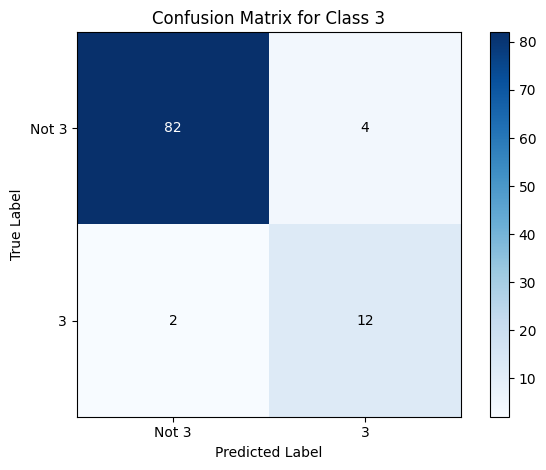

In [157]:
y_true_binary = (valid_ratio_cut['health'] == 3).astype(int)
y_pred_binary = (y_valid_integers_last == 3).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for Class 3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', 
                 color='white' if cm[i, j] > threshold else 'black')

plt.xticks(range(2), ['Not 3', '3'])
plt.yticks(range(2), ['Not 3', '3'])
plt.tight_layout()
plt.show()


In [158]:
TP_weight = 300000
TN_weight = 0
FP_weight = -100000
FN_weight = -400000

TP = cm[1, 1] * TP_weight
TN = cm[0, 0] * TN_weight
FP = cm[0, 1] * FP_weight
FN = cm[1, 0] * FN_weight

weighted_score = TP + TN + FP + FN

print(f'Weighted Score: {weighted_score}')

Weighted Score: 2400000


### Next I'll do classification for the two datasets using Random Forest

First will be on the Hardcut dataset and then the Ratiocut dataset.

In [159]:
# random forest for hard cut 

rf = RandomForestRegressor(max_depth=5, min_samples_split=3, min_samples_leaf=3, max_samples=0.3, n_estimators=50, max_features=80)

train_split = hard_cut_train[~hard_cut_train['unit_number'].isin(random_indices)]
test_split = hard_cut_train[hard_cut_train['unit_number'].isin(random_indices)]

valid_df = hard_cut_test.copy()

#####

X_columns = [column for column in train_split.columns if column != "health" and column != "health_ratio" and column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

X_train = train_split[X_columns]
X_test = test_split[X_columns]
X_valid = valid_df[X_columns]

rf.fit(X_train, train_split['health']) # fitting

y_rf_train = rf.predict(X_train) #Prediction on train data
y_rf_test = rf.predict(X_test)  #Prediction on test data
y_rf_valid_pred = rf.predict(X_valid) #Prediction on validation data

test_diff2 = hard_cut_test.copy()
test_diff2['health_pred'] = y_rf_valid_pred.round()
test_diff_pred = test_diff2.groupby('unit_number').last().reset_index()

evaluate(train_split['health'], y_rf_train, label='train')
evaluate(test_split['health'], y_rf_test, label='test')
evaluate(valid_hard_cut['health'], test_diff_pred['health_pred'], label='valid')

train set RMSE: 0.45, R2: 0.8249
test set RMSE: 0.45, R2: 0.8268
valid set RMSE: 0.68, R2: 0.5438


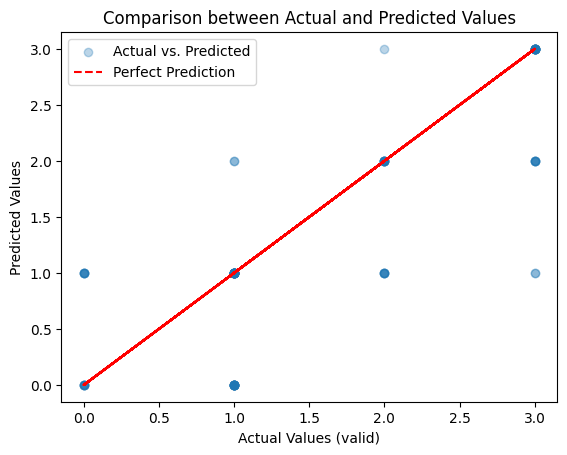

In [160]:
plt.scatter(valid_hard_cut['health'], test_diff_pred['health_pred'], label="Actual vs. Predicted", alpha=0.3)
plt.plot(valid_hard_cut['health'], valid_hard_cut['health'], color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

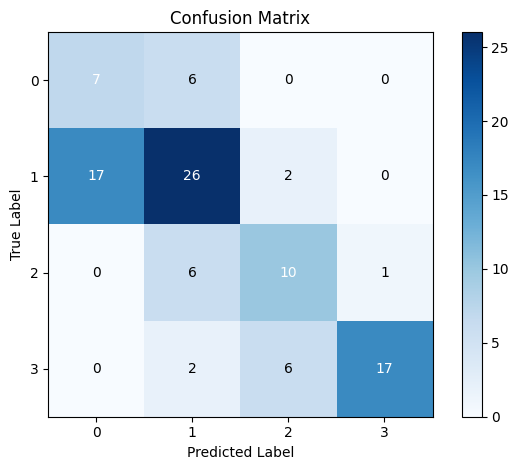

In [161]:
cm = confusion_matrix(valid_hard_cut['health'], test_diff_pred['health_pred'])

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.mean() else 'black')


plt.xticks(range(cm.shape[1]), ['0', '1', '2', '3'])
plt.yticks(range(cm.shape[0]), ['0', '1', '2', '3'])
plt.tight_layout()
plt.show()

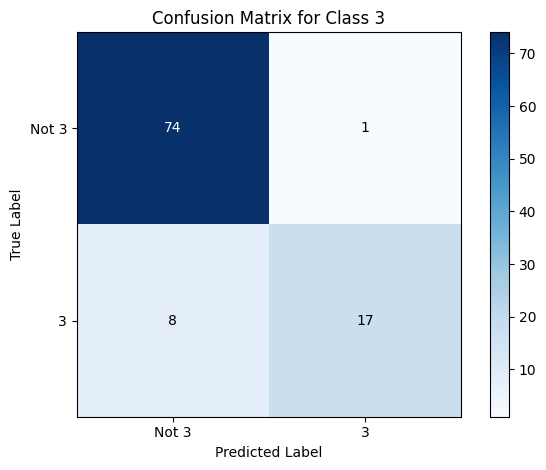

In [162]:
y_true_binary = (valid_hard_cut['health'] == 3).astype(int)
y_pred_binary = (test_diff_pred['health_pred'] == 3).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for Class 3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', 
                 color='white' if cm[i, j] > threshold else 'black')

plt.xticks(range(2), ['Not 3', '3'])
plt.yticks(range(2), ['Not 3', '3'])
plt.tight_layout()
plt.show()


In [163]:
TP_weight = 300000
TN_weight = 0
FP_weight = -100000
FN_weight = -400000

TP = cm[1, 1] * TP_weight
TN = cm[0, 0] * TN_weight
FP = cm[0, 1] * FP_weight
FN = cm[1, 0] * FN_weight

weighted_score = TP + TN + FP + FN

print(f'Weighted Score: {weighted_score}')

Weighted Score: 1800000


In [164]:
rf = RandomForestRegressor(max_depth=5, min_samples_split=3, min_samples_leaf=3, max_samples=0.3, n_estimators=50, max_features=80)

train_split = ratio_cut_train[~ratio_cut_train['unit_number'].isin(random_indices)]
test_split = ratio_cut_train[ratio_cut_train['unit_number'].isin(random_indices)]

valid_df = ratio_cut_test.copy()

#####

X_columns = [column for column in train_split.columns if column != "health" and column != "health_ratio" and column != "RUL"]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_split[X_columns])

X_train_diff_s = scaler.transform(train_split[X_columns])
X_test_diff_s = scaler.transform(test_split[X_columns])
test_corr_s = scaler.transform(valid_df[X_columns])

rf.fit(X_train_diff_s, train_split['health'])

y_rf_train = rf.predict(X_train_diff_s)
y_rf_test = rf.predict(X_test_diff_s)
y_rf_pred = rf.predict(test_corr_s)

test_diff2 = ratio_cut_test.copy()
test_diff2['health_pred'] = y_rf_pred.round()
test_diff_pred = test_diff2.groupby('unit_number').last().reset_index()

evaluate(train_split['health'], y_rf_train, label='train')
evaluate(test_split['health'], y_rf_test, label='test')
evaluate(valid_ratio_cut['health'], test_diff_pred['health_pred'], label='valid')

train set RMSE: 0.31, R2: 0.9094
test set RMSE: 0.32, R2: 0.8991
valid set RMSE: 0.45, R2: 0.7648


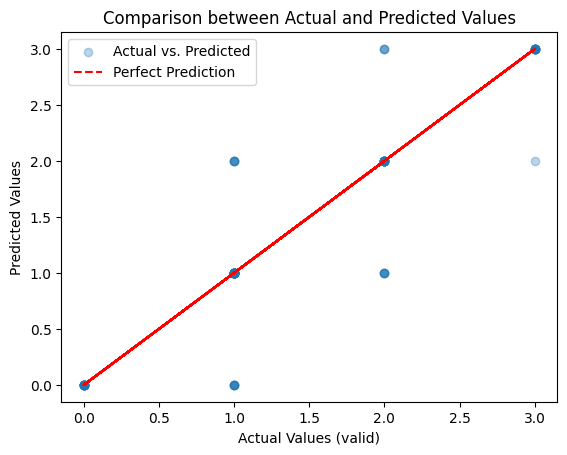

In [165]:
plt.scatter(valid_ratio_cut['health'], test_diff_pred['health_pred'], label="Actual vs. Predicted", alpha=0.3)
plt.plot(valid_ratio_cut['health'], valid_ratio_cut['health'], color='red', label="Perfect Prediction", linestyle='--')
plt.xlabel("Actual Values (valid)")
plt.ylabel("Predicted Values")
plt.title("Comparison between Actual and Predicted Values")
plt.legend()
plt.show()

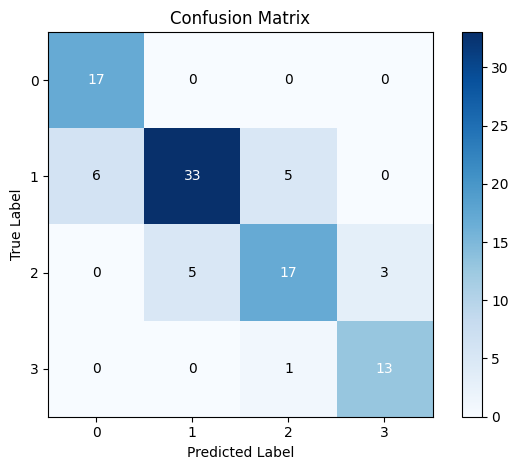

In [166]:
cm = confusion_matrix(valid_ratio_cut['health'], test_diff_pred['health_pred'])

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.mean() else 'black')


plt.xticks(range(cm.shape[1]), ['0', '1', '2', '3'])
plt.yticks(range(cm.shape[0]), ['0', '1', '2', '3'])
plt.tight_layout()
plt.show()

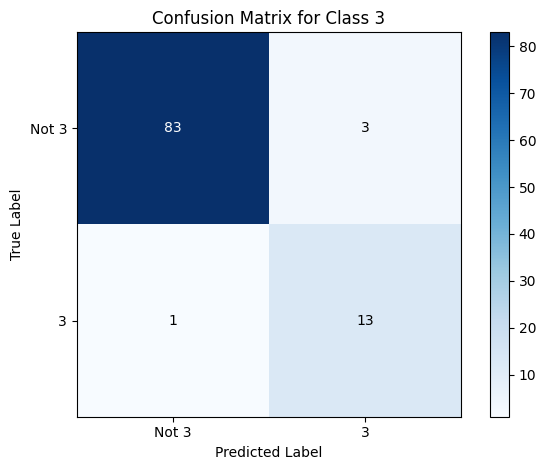

In [167]:
y_true_binary = (valid_ratio_cut['health'] == 3).astype(int)
y_pred_binary = (test_diff_pred['health_pred'] == 3).astype(int)

cm = confusion_matrix(y_true_binary, y_pred_binary)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix for Class 3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', 
                 color='white' if cm[i, j] > threshold else 'black')

plt.xticks(range(2), ['Not 3', '3'])
plt.yticks(range(2), ['Not 3', '3'])
plt.tight_layout()
plt.show()


In [168]:
TP_weight = 300000
TN_weight = 0
FP_weight = -100000
FN_weight = -400000

TP = cm[1, 1] * TP_weight
TN = cm[0, 0] * TN_weight
FP = cm[0, 1] * FP_weight
FN = cm[1, 0] * FN_weight

weighted_score = TP + TN + FP + FN

print(f'Weighted Score: {weighted_score}')

Weighted Score: 3200000


### To prevent the most damages and save the most on repair costs, it would be best to view problem as a classification problem and implement a RandomForest model for the optimial predictions.